# 0 Libraries

In [ ]:
#stable torch and torchtext version for using Glove
#pip install torch==2.2.2
#pip install torchtext==0.17.2

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchtext
import tensorflow as tf
import keras as k
import sklearn.decomposition
import pickle
import wordninja
import matplotlib.patches as mpatches
import itertools

In [61]:
from matplotlib.lines import Line2D
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import simpson
from numpy import trapz
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KernelDensity
from torchtext.vocab import GloVe
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses, Model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tqdm.autonotebook import tqdm, trange

# 1 Entity Signatures (V)

In [3]:
dfattrFullEmb = pd.read_csv(r'https://raw.githubusercontent.com/leotraeg/scoping/main/datasets_OC3HR/OC3HR_entities.csv')

## Word Embeddings (Glove)

In [4]:
## Glove Cache (automatic download if not cached)
GloveEmbeddingsFolder = r"C:\Users\leona\Meine Ablage\SS23 PhD\SP23 Independent Study (Leo)\Datasets\GloveWordEmbeddings"

In [5]:
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=50,   # embedding size = 100
                              cache=GloveEmbeddingsFolder)

In [6]:
glove300 = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=300,   # embedding size = 300
                              cache=GloveEmbeddingsFolder)

In [7]:
glove300cc = torchtext.vocab.GloVe(name="42B", # trained on Common Crawl
                              dim=300,   # embedding size = 300
                              cache=GloveEmbeddingsFolder)

In [8]:
##glove demo
def closest_words(vec, n=3):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    closestwords = [];
    for idx, difference in lst[1:n+1]: 					       # take the top n
        closestwords.append(glove.itos[idx]); #([glove.itos[idx], difference]);
    return closestwords;

In [9]:
##glove demo
def closest_words_glove300cc(vec, n=3):
    dists = torch.norm(glove300cc.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    closestwords = [];
    for idx, difference in lst[1:n+1]: 					       # take the top n
        closestwords.append(glove300cc.itos[idx]); #([glove.itos[idx], difference]);
    return closestwords;

## Sentence Transformer Bert (S-GTR-T5)

In [ ]:
#!pip install -U sentence-transformers
#pip install datasets

In [10]:
from sentence_transformers import SentenceTransformer, util

## Entity Signature (Vectorization V)

In [11]:
df_HR_ORACLE = dfattrFullEmb[(dfattrFullEmb.schema == "HR_ORACLE")].reset_index(drop=True)
df_OC_ORACLE = dfattrFullEmb[(dfattrFullEmb.schema == "OC_ORACLE")].reset_index(drop=True)
df_OC_MYSQL = dfattrFullEmb[(dfattrFullEmb.schema == "OC_MYSQL")].reset_index(drop=True)
df_OC_HANA = dfattrFullEmb[(dfattrFullEmb.schema == "OC_HANA")].reset_index(drop=True)

df_OC_ORACLE_OC_MYSQL_OC_HANA = dfattrFullEmb[(dfattrFullEmb.schema != "HR_ORACLE")].reset_index(drop=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = dfattrFullEmb.copy()

In [12]:
def df_toEmbeddings(df_emb):
  concept_embeddings = [];
  concept_embedding300 = [];
  concept_embedding300cc = [];
  emb_hyperparemter = 0.8;

  #sgtrt5 schema
  model = SentenceTransformer('sentence-transformers/gtr-t5-base')
  ce_x_sgtrt5_s = model.encode(df_emb.concept_concat_sgtrt5.values)

  #sgtrt5 schema+instances
  ce_x_sgtrt5_si = model.encode(df_emb.concept_concat_schema_instances_sgtrt5.values)


  for index, row in df_emb.iterrows():
    #table
    sum_table_vector = torch.tensor(np.zeros(50), dtype=torch.float64) #same data type of tensor important
    sum_table_vector300 = torch.tensor(np.zeros(300), dtype=torch.float64) #same data type of tensor important
    sum_table_vector300cc = torch.tensor(np.zeros(300), dtype=torch.float64) #same data type of tensor important
    refined_local_name_p = wordninja.split(row["refined_local_name_p"])
    table_vector = glove[row["refined_local_name_p"]];
    #table embedding
    for word in refined_local_name_p:
      sum_table_vector = sum_table_vector + glove[word];
      sum_table_vector300 = sum_table_vector300 + glove300[word];
      sum_table_vector300cc = sum_table_vector300cc + glove300cc[word];

    #attr
    sum_attr_vector = torch.tensor(np.zeros(50), dtype=torch.float64) #same data type of tensor important
    sum_attr_vector300  = torch.tensor(np.zeros(300), dtype=torch.float64) #same data type of tensor important
    sum_attr_vector300cc = torch.tensor(np.zeros(300), dtype=torch.float64) #same data type of tensor important
    refined_local_name = wordninja.split(row["refined_local_name"])
    #attr embedding
    for word in refined_local_name:
      if torch.cosine_similarity(glove[word].unsqueeze(0), table_vector.unsqueeze(0))[0].item() < emb_hyperparemter or len(refined_local_name) == 1:
        sum_attr_vector = sum_attr_vector + glove[word];
        sum_attr_vector300 = sum_attr_vector300 + glove300[word];
        sum_attr_vector300cc = sum_attr_vector300cc + glove300cc[word];

    concept_embedding = torch.tensor(np.append(np.append(sum_table_vector, sum_attr_vector),
                                              [item for item in row[5:15].values.tolist()]) #start from col index of schema [5]
                                    );

    concept_embedding300 = torch.tensor(np.append(np.append(sum_table_vector300, sum_attr_vector300),
                                              [item for item in row[5:15].values.tolist()])
                                    );

    concept_embedding300cc = torch.tensor(np.append(np.append(sum_table_vector300cc, sum_attr_vector300cc),
                                              [item for item in row[5:15].values.tolist()])
                                    );

    concept_embeddings.append([row["id"],
                              row["refined_local_name"],
                              row["refined_local_name_p"],
                              row["schema"],
                              concept_embedding, #50
                              concept_embedding300, #300
                              concept_embedding300cc, #300cc
                              ce_x_sgtrt5_s[index],
                              np.append(ce_x_sgtrt5_s[index],[item for item in row[5:15].values.tolist()]),
                              ce_x_sgtrt5_si[index],
                              0, #reconstruction_error
                              np.append(ce_x_sgtrt5_si[index],[item for item in row[5:15].values.tolist()]),
                              ]);
  return concept_embeddings;

In [199]:
def concept_embeddings_to_ce_x(concept_embeddings, signature_variant):
  ce_x = [];
  for concept in concept_embeddings:
    if(isinstance(concept[ce_get(signature_variant)], np.ndarray)):
      ce_x.append(concept[ce_get(signature_variant)])
    else:
      ce_x.append(concept[ce_get(signature_variant)].numpy());
  return np.array(ce_x);

In [200]:
def ce_get(variant):
  if(variant=="id"):
    return 0;
  if(variant=="name"):
    return 1;
  if(variant=="pname"):
    return 2;
  if(variant=="schema"):
    return 3;
  if(variant=="50"):
    return 4;
  if(variant=="300"):
    return 5;
  if(variant=="300cc" or variant =="Glove_s"):
    return 6;
  if(variant=="sgtrt5" or variant =="gtrt5_s"):
    return 7;
  if(variant=="sgtrt5_dc" or variant == "gtrt5_dc"):
    return 8;
  if(variant=="sgtrt5_si" or variant == "gtrt5_si" or variant == "gtrt5_s+i"):
    return 9;
  if(variant=="reconstruction_error"):
    return 10;
  if(variant=="sgtrt5_si_dc" or variant == "gtrt5_si_dc"):
    return 11;

In [ ]:
#ce_HR_ORACLE = df_toEmbeddings(df_HR_ORACLE)
#ce_OC_ORACLE = df_toEmbeddings(df_OC_ORACLE)
#ce_OC_MYSQL = df_toEmbeddings(df_OC_MYSQL)
#ce_OC_HANA = df_toEmbeddings(df_OC_HANA)

In [15]:
ce_OC_ORACLE_OC_MYSQL_OC_HANA = df_toEmbeddings(df_OC_ORACLE_OC_MYSQL_OC_HANA);

c:\Users\leona\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = df_toEmbeddings(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

## Ground Truth Linkages

In [95]:
df_gt_mappings = pd.read_csv('https://raw.githubusercontent.com/leotraeg/scoping/main/datasets_OC3HR/gt_adjacency_list.csv')

In [96]:
df_gt_mappings

Attribute_A  Attribute_B  Bool      Cannonical_Name       Type  \
0    CONCEPT_46   CONCEPT_97     1          Customer ID  Attribute   
1    CONCEPT_46  CONCEPT_165     1          Customer ID  Attribute   
2    CONCEPT_97  CONCEPT_165     1          Customer ID  Attribute   
3    CONCEPT_48   CONCEPT_98     1        Customer Name  Attribute   
4    CONCEPT_48  CONCEPT_169     1        Customer Name  Attribute   
..          ...          ...   ...                  ...        ...   
57  CONCEPT_127   CONCEPT_12     1           Office ZIP  Attribute   
58  CONCEPT_121   CONCEPT_13     1     Office City Name  Attribute   
59  CONCEPT_125   CONCEPT_14     1    Office State Name  Attribute   
60  CONCEPT_126    CONCEPT_7     1  Office Country Name  Attribute   
61  CONCEPT_128    CONCEPT_4     1   Office Region Name  Attribute   

       Schemas_Mapping  
0   OC_ORACLE-OC_MYSQL  
1    OC_ORACLE-OC_HANA  
2     OC_MYSQL-OC_HANA  
3   OC_ORACLE-OC_MYSQL  
4    OC_ORACLE-OC_HANA  
..                 ...  
57  HR_ORACLE-OC_MYSQL  
58  HR_ORACLE-OC_MYSQL  
59  HR_ORACLE-OC_MYSQL  
60  HR_ORACLE-OC_MYSQL  
61  HR_ORACLE-OC_MYSQL  

[62 rows x 6 columns]

In [97]:
df_gt_mappings_OC3 = df_gt_mappings[(df_gt_mappings["Schemas_Mapping"].str.contains("HR_ORACLE")==False)]
# GROUND TRUTH with concept names (domain-specific)
gt_OC_ORACLE_OC_MYSQL_OC_HANA = []
# GROUND TRUTH with concept ids (domain-specific)
gt_id_OC_ORACLE_OC_MYSQL_OC_HANA = []


for index, row in df_gt_mappings_OC3.iterrows():
    gt_OC_ORACLE_OC_MYSQL_OC_HANA.append((df_OC_ORACLE_OC_MYSQL_OC_HANA[df_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_A']].refined_local_name.item(),
                                          df_OC_ORACLE_OC_MYSQL_OC_HANA[df_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_B']].refined_local_name.item()))
    gt_id_OC_ORACLE_OC_MYSQL_OC_HANA.append((df_OC_ORACLE_OC_MYSQL_OC_HANA[df_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_A']].id.item(),
                                             df_OC_ORACLE_OC_MYSQL_OC_HANA[df_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_B']].id.item()))

In [98]:
df_gt_mappings_OC3HR = df_gt_mappings
# GROUND TRUTH with concept names (domain-agnostic)
gt_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = []
# GROUND TRUTH with concept ids (domain-agnostic)
gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = []

for index, row in df_gt_mappings_OC3HR.iterrows():
    gt_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.append((df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_A']].refined_local_name.item(),
                                                    df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_B']].refined_local_name.item()))
    gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.append((df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_A']].id.item(),
                                                       df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_B']].id.item()))

## OC3-HR Visualization with PCA(2)

In [48]:
source_dict = {"OC_ORACLE": "tab:red", "OC_MYSQL": "tab:orange", "OC_HANA": "tab:blue", "HR_ORACLE": "tab:green"}

In [49]:
source_dict_marker = {"OC_ORACLE": "o", "OC_MYSQL": "s", "OC_HANA": "X", "HR_ORACLE": "^"}

In [50]:
def entity_index_by_id(ce, entity_id):
  return ce.index([entity for entity in ce if entity[0] == entity_id][0])

In [51]:
def pca_visualization(ce, variant, gt, min_max_scale=True):
  nComp=2
  scaler = MinMaxScaler(feature_range = (0,1))

  ce_x = concept_embeddings_to_ce_x(ce, variant)
  ce_x = scaler.fit_transform(ce_x)

  #pca
  mu = np.mean(ce_x, axis=0)
  nComp = nComp
  pca = sklearn.decomposition.PCA(n_components=nComp)
  pca.fit(ce_x)
  ce_x_reduced = pca.transform(ce_x)

  alpha_cust = .8
  sources = []
  #plot entities
  for i, entity in enumerate(ce):
    plt.plot(ce_x_reduced[i][0], ce_x_reduced[i][1], source_dict_marker[entity[3]], c=source_dict[entity[3]],
             markersize=10, alpha=alpha_cust)
    sources.append(entity[3])

  #plot linkages
  for linkage in gt:
    #linkage contains set of two CONCEPT ids e.g., ("CONCEPT_1, CONCEPT_2")
    a_index = entity_index_by_id(ce, linkage[0])
    b_index = entity_index_by_id(ce, linkage[1])
    plt.plot([ce_x_reduced[a_index][0], ce_x_reduced[b_index][0]], [ce_x_reduced[a_index][1], ce_x_reduced[b_index][1]], linestyle=":", color="black", alpha=0.3)

  #handles, labels = ax.get_legend_handles_labels()
  legend_elements =[]

  if "HR_ORACLE" in set(sources):
    linkages_text = "Linkages (62)"
    title_text = "OC3-HR (domain-agnostic)"# compressed " + variant + " via PCA(2)"
  else:
    linkages_text = "Linkages (47)"
    title_text = "OC3 (domain-specific)"# compressed " + variant + " via PCA(2)"

  for source in sorted(set(sources)):
    legend_elements.append(Line2D([0], [0], marker=source_dict_marker[source], color='w', label=source, markerfacecolor=source_dict[source], markersize=10))
  legend_elements.append(Line2D([0], [0], color='dimgray', label=linkages_text, markerfacecolor="black", linestyle='dashed'))
  plt.legend(handles=legend_elements)
  plt.title(title_text)
  plt.show()


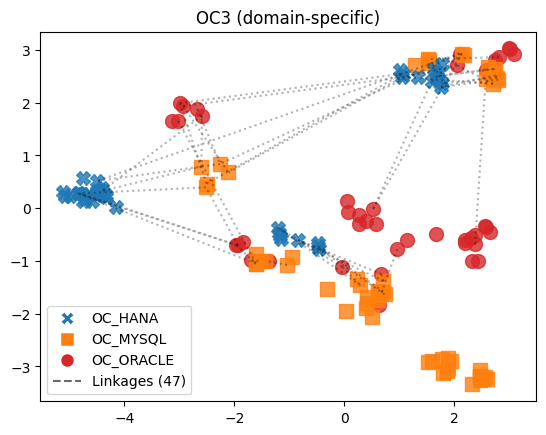

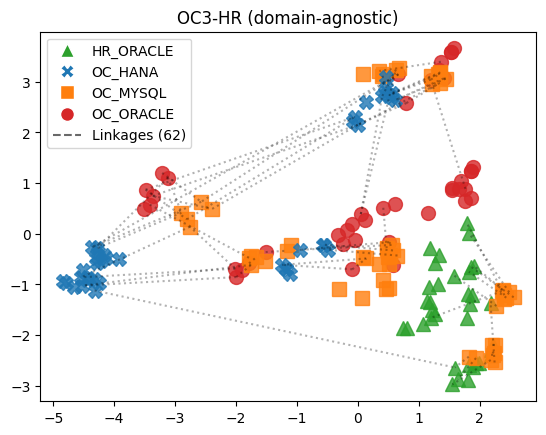

In [54]:
pca_visualization(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "Glove_s", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)
pca_visualization(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "Glove_s", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

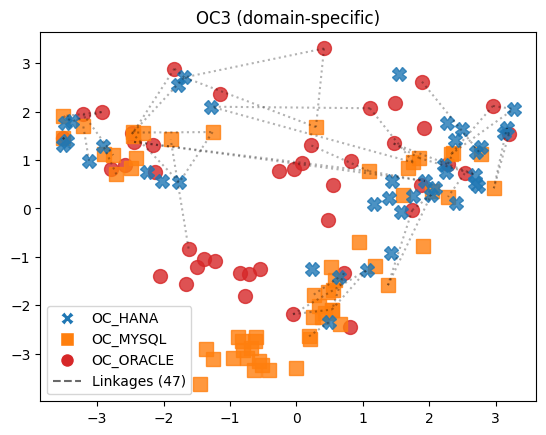

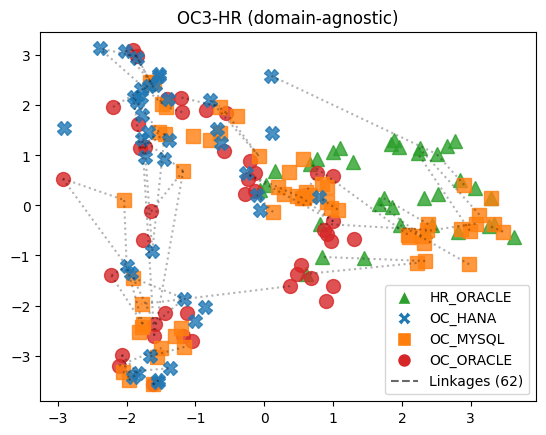

In [55]:
pca_visualization(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "gtrt5_s", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)
pca_visualization(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "gtrt5_s", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

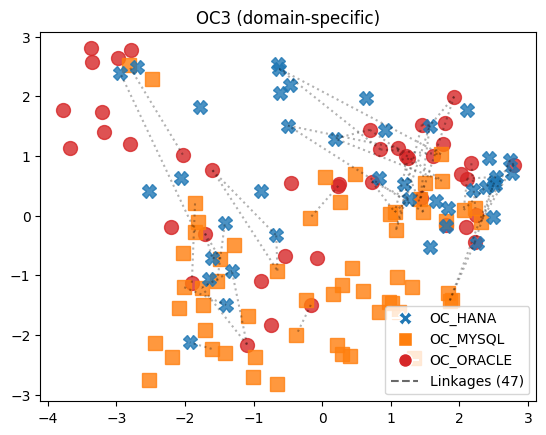

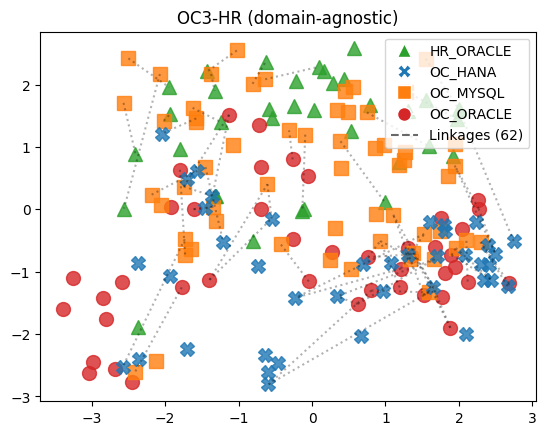

In [56]:
pca_visualization(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "gtrt5_s+i", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)
pca_visualization(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "gtrt5_s+i", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

# 2.0 Scoping Ranking (R) Baseline

## Z-Score

In [57]:
def method_zscore(ce_x):
  #Min Max Scaling for Z-Score unneccesary

  z_score = abs(stats.zscore(ce_x))
  #compute new vector length without nan dimensions (meaning: all samples are equal on this dimension)
  dim_len_without_npnan = np.count_nonzero(~np.isnan(z_score[0]))
  #create new z-score vector by mean all dimensions
  return z_score[~np.isnan(z_score)].reshape((len(ce_x), dim_len_without_npnan)).mean(axis=1)

## LOF

In [58]:
def method_clf(ce_x, metric="cosine", n_neighbors=15, min_max_scale=False):
  #do 0..1 scaling of embeddings
  if min_max_scale==True:
    scaler = MinMaxScaler(feature_range = (0,1))
    ce_x = scaler.fit_transform(ce_x)

  clf = LocalOutlierFactor(n_neighbors=n_neighbors)
  clf.fit_predict(ce_x)

  return clf.negative_outlier_factor_* -1

# 2.1 Scoping Ranking (R) Encoder-Decoder MSE

## PCA

In [59]:
def method_pca(ce_x, nComp, min_max_scale=False):
  #do 0..1 scaling of embeddings
  if min_max_scale==True:
    scaler = MinMaxScaler(feature_range = (0,1))
    ce_x = scaler.fit_transform(ce_x)

  #pca
  mu = np.mean(ce_x, axis=0)
  nComp = nComp
  pca = sklearn.decomposition.PCA(n_components=nComp)
  pca.fit(ce_x)
  decoded = np.dot(pca.transform(ce_x)[:,:nComp], pca.components_[:nComp,:])
  decoded += mu

  #return mse between original input / encoder-decoder input
  return pd.Series(map(mean_squared_error, ce_x, decoded)), pca

## PKDE (not part of paper submission)
High dimensional outlier detection method based on: https://arxiv.org/pdf/1909.03681
"The kernel function effectively transforms the Euclidean norm into a nonlinear norm."

In [64]:
def method_pkde(ce_x, nComp=2, bandwidth=1, min_max_scale=False):
  #do 0..1 scaling of embeddings
  if min_max_scale==True:
    scaler = MinMaxScaler(feature_range = (0,1))
    ce_x = scaler.fit_transform(ce_x)

  #pca
  mu = np.mean(ce_x, axis=0)
  nComp = nComp
  pca = sklearn.decomposition.PCA(n_components=nComp)
  pca.fit(ce_x)
  ce_x_reduced = pca.transform(ce_x)

  #kde
  kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(ce_x_reduced)
  log_density = kde.score_samples(ce_x_reduced)

  #return log-likelihood of each sample (log_density)
  return pd.Series(log_density*-1)

In [65]:
def method_kde(ce_x, bandwidth=1, min_max_scale=False):
  #do 0..1 scaling of embeddings
  if min_max_scale==True:
    scaler = MinMaxScaler(feature_range = (0,1))
    ce_x = scaler.fit_transform(ce_x)

  #kde
  kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(ce_x)
  log_density = kde.score_samples(ce_x)

  #return log-likelihood of each sample (log_density)
  return pd.Series(log_density*-1)

In [ ]:
# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_pkde_sgtrt5_p2_b1"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), nComp=2, bandwidth=1, min_max_scale=True)
# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_pkde_sgtrt5_p2_b0.5"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), nComp=2, bandwidth=0.5, min_max_scale=True)
# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_pkde_sgtrt5_p2_b0.2"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), nComp=2, bandwidth=0.2, min_max_scale=True)
# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_pkde_sgtrt5_p100_b1"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), nComp=100, bandwidth=1, min_max_scale=True)
# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_pkde_sgtrt5_p100_b0.5"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), nComp=100, bandwidth=0.5, min_max_scale=True)
# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_pkde_sgtrt5_p100_b0.2"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), nComp=100, bandwidth=0.2, min_max_scale=True)

# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_kde_sgtrt5_b1"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), bandwidth=1, min_max_scale=True)
# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_kde_sgtrt5_b0.5"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), bandwidth=0.5, min_max_scale=True)
# df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_kde_sgtrt5_b0.2"] = method_pkde(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), bandwidth=0.2, min_max_scale=True)

In [ ]:
#   Setting	                                    AUC_PC_trapezoidal	AUC_HM_trapezoidal
# 0	reconstruction_error_pkde_sgtrt5_p2_b1	    33.904255	        30.551724
# 1	reconstruction_error_pkde_sgtrt5_p2_b0.5	31.797872	        26.753153
# 2	reconstruction_error_pkde_sgtrt5_p2_b0.2	30.500000	        25.277328
# 3	reconstruction_error_pkde_sgtrt5_p100_b1	54.106383	        43.637614
# 4	reconstruction_error_pkde_sgtrt5_p100_b0.5	51.489362	        43.161433
# 5	reconstruction_error_pkde_sgtrt5_p100_b0.2	44.446809	        37.315976
# 6	reconstruction_error_kde_sgtrt5_b1	        33.904255	        30.551724
# 7	reconstruction_error_kde_sgtrt5_b0.5	    31.797872	        26.753153
# 8	reconstruction_error_kde_sgtrt5_b0.2	    30.500000	        25.277328

## Autoencoder

In [66]:
def method_ae_v0(ce_x, max_iter=10, loss=losses.MeanSquaredError(), epochs=10, inb_layer=300, bottleneck=100):
  emb_len = len(ce_x[0])
  iteration = 0;
  reconstruction_error_sum = np.zeros(shape=(len(ce_x),));

  #mms normalization
  scaler = MinMaxScaler(feature_range = (0,1))
  ce_x_scaled = scaler.fit_transform(ce_x)

  while (iteration < max_iter+1):
    #test train split
    ce_x_scaled_train, ce_x_scaled_test = train_test_split(ce_x_scaled, test_size=.2)

    #model
    #functional Keras annotation
    enc_input = tf.keras.Input(shape=(emb_len,), name="concat_all")
    enc_features = tf.keras.layers.Dense(inb_layer, activation='relu')(enc_input)
    enc_output = tf.keras.layers.Dense(bottleneck, activation='relu')(enc_features)
    encoder = tf.keras.Model(
        inputs=[enc_input],
        outputs=[enc_output],
        name="encoder")

    dec_input = tf.keras.Input(shape=(bottleneck,), name="decoder")
    dec_features = tf.keras.layers.Dense(bottleneck, activation='relu')(enc_output)
    dec_features = tf.keras.layers.Dense(inb_layer, activation='relu')(dec_features)
    dec_output = tf.keras.layers.Dense(emb_len, activation='relu', name="reconstructed")(dec_features)
    autoencoder = tf.keras.Model(
        inputs=[enc_input],
        outputs=[dec_output],
        name="autoencoder")

    #compile
    autoencoder.compile(optimizer='adam', loss=loss)

    #fit
    autoencoder.fit(
      {"concat_all": ce_x_scaled_train},
      {"reconstructed": ce_x_scaled_train},
      epochs=epochs,
      shuffle=True,
      verbose=0,
      validation_data=({"concat_all": ce_x_scaled_test}))

    #reconstruction
    reconstruction_error_sum = reconstruction_error_sum + tf.reduce_sum(
      (autoencoder({"concat_all": ce_x_scaled}) - ce_x_scaled)**2, axis=1)

    iteration = iteration + 1;

  return pd.DataFrame({ "reconstruction_error": reconstruction_error_sum }) #reconstruction_errors

## RandNet (not part of paper submission)
High dimensional outlier detection method based on: https://epubs.siam.org/doi/abs/10.1137/1.9781611974973.11
"Outlier Detection with Autoencoder Ensembles"

In [ ]:
class RandAE(tf.keras.Sequential):
    def __init__(self, input_dim, hidden_dims, drop_ratio=0.5, **kwargs):
        super(RandAE, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.drop_ratio = drop_ratio

        self.layer_masks = dict()

        self.build_model()

    def build_model(self) -> None:
        """
        Adds the layers and records masks.
        """
        input_layer = tf.keras.Input(shape=(self.input_dim,), name="input")
        self.add(input_layer)

        for i, dim in enumerate(self.hidden_dims):
            layer_name = f"hidden_{i}"
            layer = tf.keras.layers.Dense(dim,
                                 activation="relu" if i > 0 else "sigmoid",
                                 name=layer_name)
            self.add(layer)

            # add layer mask
            self.layer_masks[layer_name] = self.get_mask(layer)

        output_layer = tf.keras.layers.Dense(self.input_dim, activation="sigmoid", name="output")
        self.add(output_layer)
        self.layer_masks[layer_name] = self.get_mask(output_layer)

    def get_mask(self, layer) -> np.ndarray:
        """
        Build mask for a layer.
        """

        shape = layer.input_shape[1], layer.output_shape[1]

        return np.random.choice([0., 1.], size=shape, p=[self.drop_ratio, 1-self.drop_ratio])

    def load_masks(self, mask_pickle_path) -> None:
        """
        Load the masks from a pickled dictionary.
        """

        with open(mask_pickle_path, 'rb') as handle:
            self.layer_masks = pickle.load(handle)

    def get_encoder(self) -> k.Sequential:
        """
        Get the encoder from the full model.
        """

        n_layers = (len(self.hidden_dims)+1)//2
        encoder_layers = [layers.Input(self.input_dim)] + self.layers[:n_layers]

        return k.Sequential(encoder_layers)


    def mask_weights(self) -> None:
        """
        Apply the masks to each layer in the encoder and decoder.
        """

        for layer in self.layers:
          layer_name = layer.name
          if layer_name in self.layer_masks:
            masked_w = layer.weights[0].numpy()*self.layer_masks[layer_name]
            b = layer.weights[1].numpy()
            layer.set_weights((masked_w, b))

    def call(self, data, training=True) -> tf.Tensor:

        # mask the weights before original forward pass
        #self.mask_weights()

        return super().call(data)

In [ ]:
def method_randnet(ce_x, max_iter=10, loss=losses.MeanSquaredError(), epochs=10, hidden_dims=[64,32,64], a=0.5):
  emb_len = len(ce_x[0])
  iteration = 0;
  reconstruction_error_sum = np.zeros(shape=(len(ce_x),));

  #mms normalization
  scaler = MinMaxScaler(feature_range = (0,1))
  ce_x_scaled = scaler.fit_transform(ce_x)

  while (iteration < max_iter+1):
    model = RandAE(emb_len, hidden_dims, drop_ratio=a)
    #compile
    model.compile(optimizer="adam", loss=loss, run_eagerly=True)

    #fit
    model.fit(ce_x_scaled, #input
              ce_x_scaled, #output
              epochs=epochs,
              batch_size=32, #default
              verbose=0,
              shuffle=True)

    # make ensemble predictions
    pred = model.predict(ce_x_scaled,
                         verbose=0)

    # calculate reconstruction MSE
    reconstruction_error = np.square(pred - ce_x_scaled).mean(axis=1)

    # normalization to devation of one unit
    reconstruction_error_normalized = reconstruction_error/np.linalg.norm(reconstruction_error)

    # stack reconstruction error
    if iteration == 0:
      reconstruction_error_vstack = reconstruction_error_normalized
    else:
      reconstruction_error_vstack = np.c_[reconstruction_error_vstack, reconstruction_error_normalized]

    # sum reconstruction error
    reconstruction_error_sum = reconstruction_error_sum + reconstruction_error_normalized

    iteration = iteration + 1;

  #reconstruction_errors
  return pd.DataFrame({ "reconstruction_error_sum": reconstruction_error_sum,
                        "reconstruction_error_median": np.median(reconstruction_error_vstack, axis=1)})

In [ ]:
ce_OC3_sgtrt5 = concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5")

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA[["re_randnet_sgtrt5_v1_mean","re_randnet_sgtrt5_v1_median"]]  = method_randnet(ce_OC3_sgtrt5, max_iter=20, hidden_dims=[300,10,300])
df_OC_ORACLE_OC_MYSQL_OC_HANA[["re_randnet_sgtrt5_v2_mean","re_randnet_sgtrt5_v2_median"]]  = method_randnet(ce_OC3_sgtrt5, max_iter=20, hidden_dims=[256,64,32,64,256])
df_OC_ORACLE_OC_MYSQL_OC_HANA[["re_randnet_sgtrt5_v3_mean","re_randnet_sgtrt5_v3_median"]]  = method_randnet(ce_OC3_sgtrt5, max_iter=20, hidden_dims=[256,64,256])
df_OC_ORACLE_OC_MYSQL_OC_HANA[["re_randnet_sgtrt5_v4_mean","re_randnet_sgtrt5_v4_median"]]  = method_randnet(ce_OC3_sgtrt5, max_iter=20, hidden_dims=[300,10,300], a=0.3)
df_OC_ORACLE_OC_MYSQL_OC_HANA[["re_randnet_sgtrt5_v5_mean","re_randnet_sgtrt5_v5_median"]]  = method_randnet(ce_OC3_sgtrt5, max_iter=20, hidden_dims=[256,64,256], a=0.3)

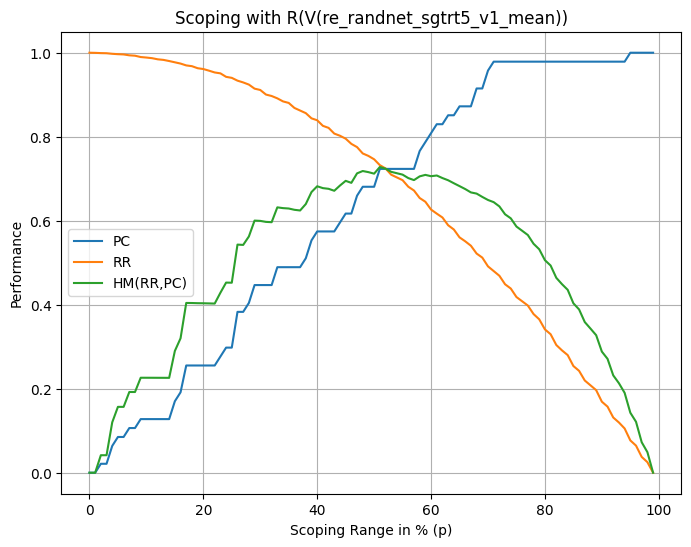

AUC PC (trapezoidal rule):  61.50000000000001
AUC HM (trapezoidal rule):  47.702690127091


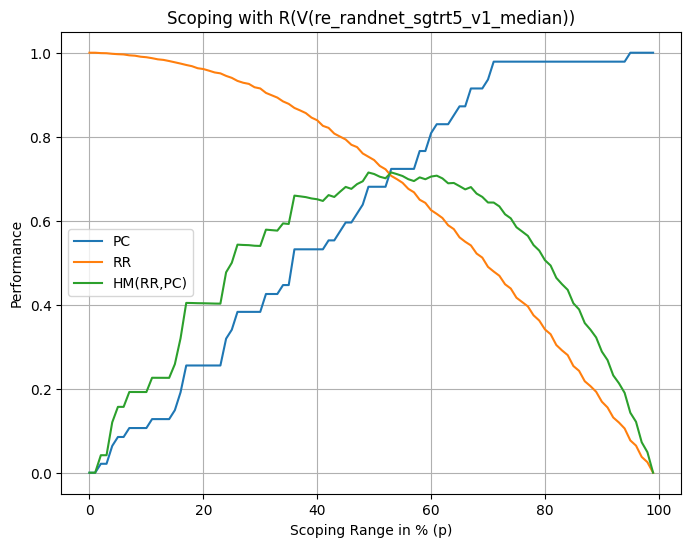

AUC PC (trapezoidal rule):  60.840425531914896
AUC HM (trapezoidal rule):  47.12563476792401


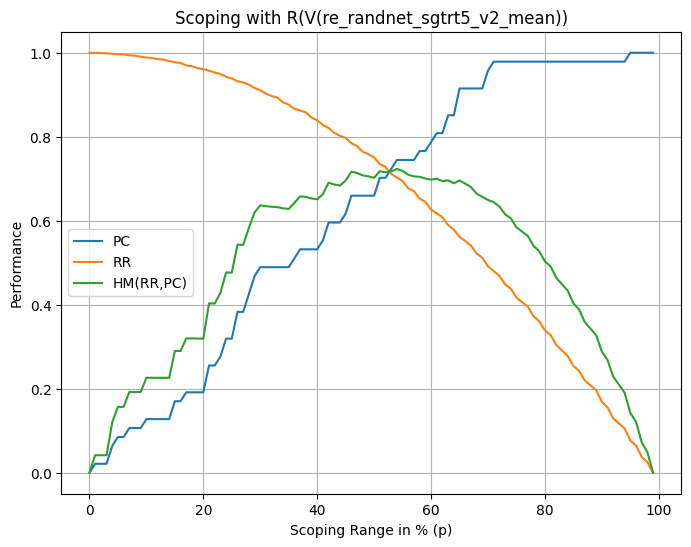

AUC PC (trapezoidal rule):  61.54255319148937
AUC HM (trapezoidal rule):  47.5664682823058


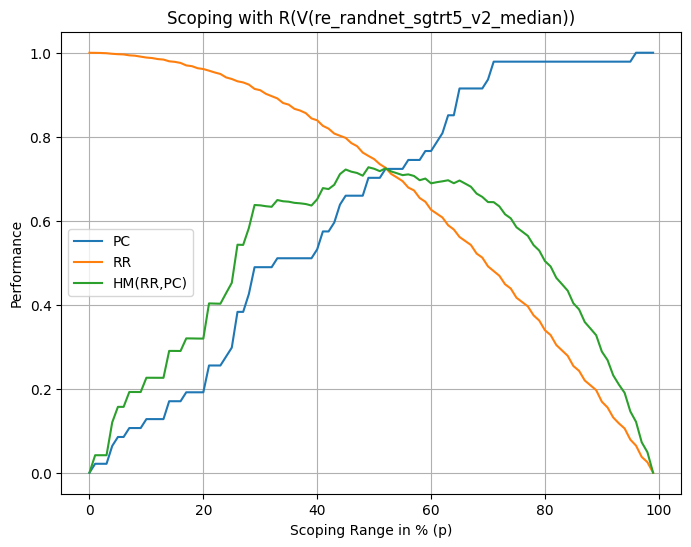

AUC PC (trapezoidal rule):  61.56382978723405
AUC HM (trapezoidal rule):  47.61645713515733


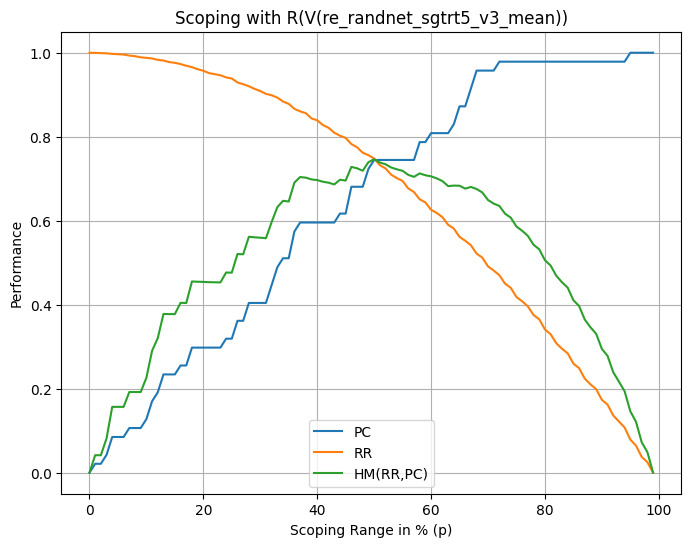

AUC PC (trapezoidal rule):  62.925531914893625
AUC HM (trapezoidal rule):  49.18447993599699


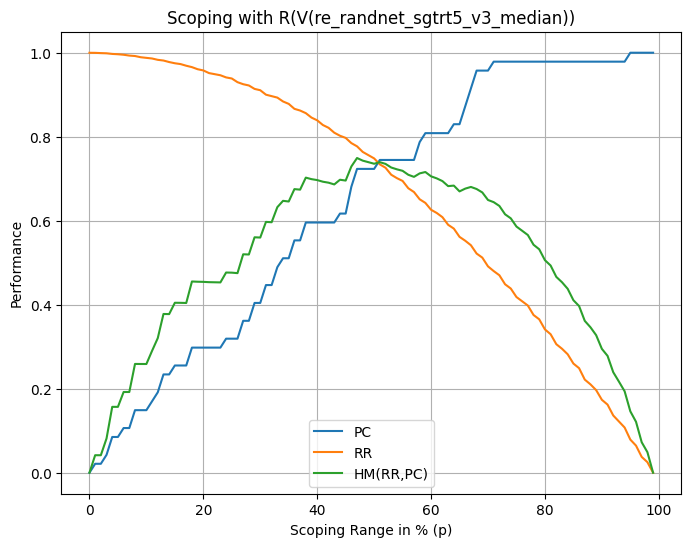

AUC PC (trapezoidal rule):  63.031914893617035
AUC HM (trapezoidal rule):  49.34514629786533


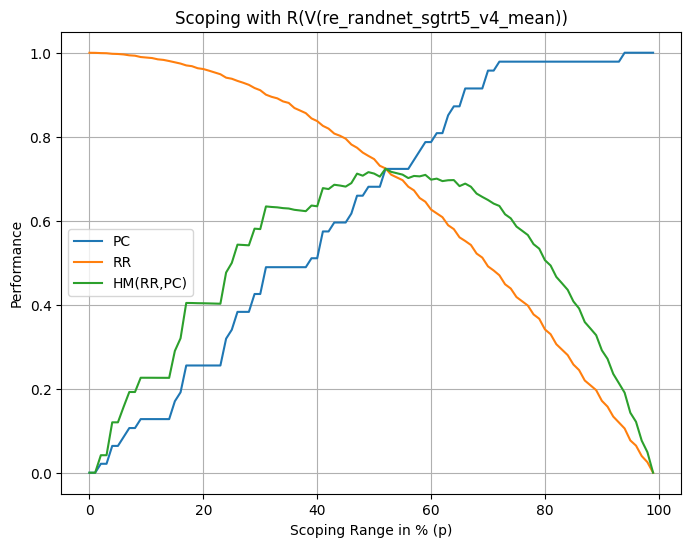

AUC PC (trapezoidal rule):  61.41489361702128
AUC HM (trapezoidal rule):  47.63328504816727


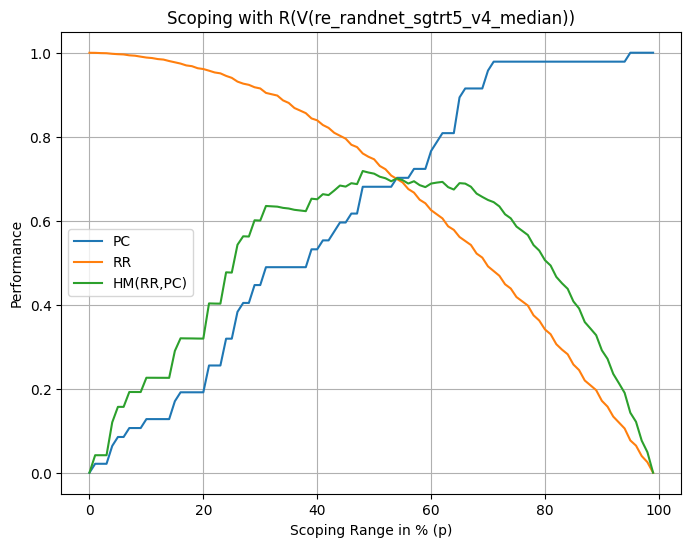

AUC PC (trapezoidal rule):  60.797872340425535
AUC HM (trapezoidal rule):  47.17890646116346


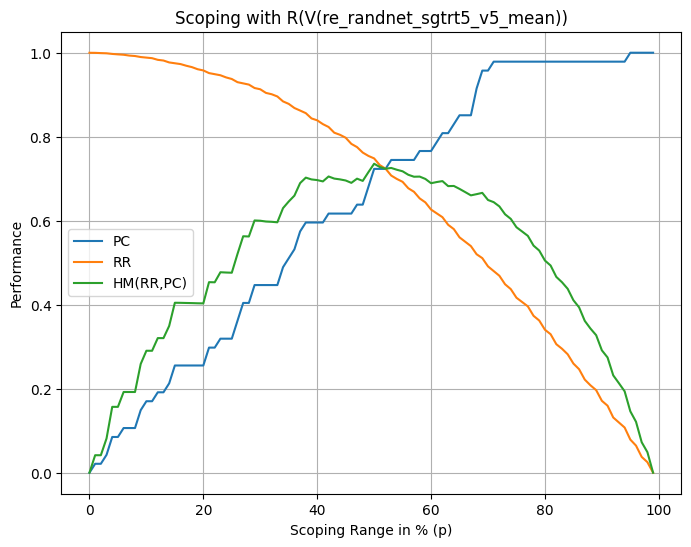

AUC PC (trapezoidal rule):  62.47872340425533
AUC HM (trapezoidal rule):  48.973893409273245


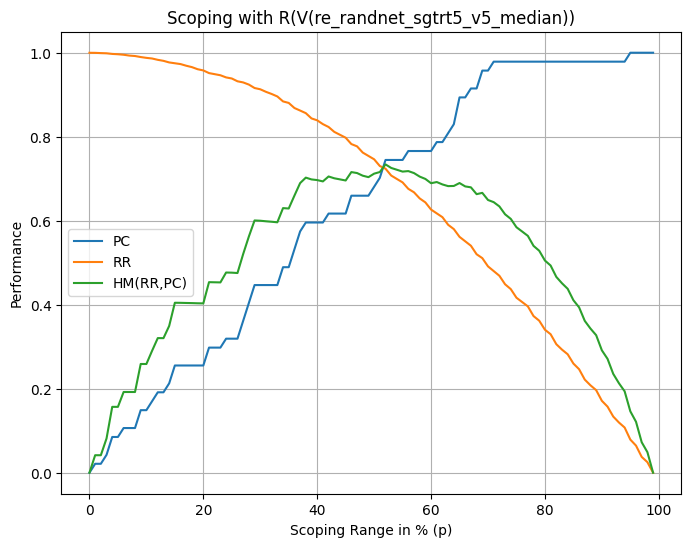

AUC PC (trapezoidal rule):  62.52127659574469
AUC HM (trapezoidal rule):  48.88152624999704


Setting  AUC_PC_trapezoidal  AUC_HM_trapezoidal
0    re_randnet_sgtrt5_v1_mean           61.500000           47.702690
1  re_randnet_sgtrt5_v1_median           60.840426           47.125635
2    re_randnet_sgtrt5_v2_mean           61.542553           47.566468
3  re_randnet_sgtrt5_v2_median           61.563830           47.616457
4    re_randnet_sgtrt5_v3_mean           62.925532           49.184480
5  re_randnet_sgtrt5_v3_median           63.031915           49.345146
6    re_randnet_sgtrt5_v4_mean           61.414894           47.633285
7  re_randnet_sgtrt5_v4_median           60.797872           47.178906
8    re_randnet_sgtrt5_v5_mean           62.478723           48.973893
9  re_randnet_sgtrt5_v5_median           62.521277           48.881526

In [ ]:
auc = []
for eval_col in df_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("_me")]:
  auc.append(performance_plot(df_OC_ORACLE_OC_MYSQL_OC_HANA, eval_col, gt_id_OC_ORACLE_OC_MYSQL_OC_HANA))
pd.DataFrame(auc, columns=["Setting", "AUC_PC_trapezoidal", "AUC_HM_trapezoidal"])

# 2.2 Scoping Framework
Given p threshold value and matching sequence (blocking)

In [68]:
def entity_collection_to_block(entity_collection, start_percentile, end_percentile):
  return entity_collection[(entity_collection.index>=np.percentile(entity_collection.index, start_percentile)) &
                           (entity_collection.index<=np.percentile(entity_collection.index, end_percentile))]

In [69]:
def entity_collection_to_dataframes(entity_collection):
  schemas = {}

  for schema_key in entity_collection.sort_values(by=['schema'], ascending=False)['schema'].unique():
    entity_collection_schema = entity_collection[entity_collection["schema"]== schema_key]
    entity_collection_table_key = entity_collection_schema['refined_local_name_p'].unique()

    schema = {}
    for table_key in entity_collection_table_key:
      entity_collection_table = entity_collection_schema[entity_collection_schema["refined_local_name_p"] == table_key]
      entity_collection_attribute_key = entity_collection_table['refined_local_name'].unique()
      schema[table_key] = pd.DataFrame(columns=entity_collection_attribute_key)

    schemas[schema_key] = schema

  return schemas;

In [70]:
#This function creates all possible matching sequences between schemas:
#The output includes SCHEMA1:customer:customernumber, SCHEMA2:client:clientid and
#                    SCHEMA2:client:clientid, SCHEMA1:customer:customernumber
def holistic_matching_sequence(entity_collection):
  mapping_sequence = []
  schema_key_curr = ""

  for schema_key_a, table_keys_a in entity_collection.items():
    schema_key_curr = schema_key_a #set current schema

    for table_key_a, attributes_df_a in table_keys_a.items():
      #extract df for each table_key

      for schema_key_b, table_keys_b in entity_collection.items():
        #loop through all schemas (again)
        if schema_key_curr == schema_key_b:
          #exclude schema_key_a
          continue
        else:
          for schema_key_b, attributes_df_b in table_keys_b.items():
            #cartesian product between table_a_columns and table_b_columns
            mapping_sequence = mapping_sequence + [matching for matching in itertools.product(attributes_df_a.columns.tolist(), attributes_df_b.columns.tolist())]

  return mapping_sequence


In [172]:
#This function creates all possible matching sequences between schemas:
#Limited to a_b order of the schema list (SCHEMA1>SCHEMA2>...)
#It includes SCHEMA1:customer:customernumber, SCHEMA2:client:clientid
#But not     SCHEMA2:client:clientid, SCHEMA1:customer:customernumber
def holistic_matching_sequence_ab_n(entity_collection):
  schema_key_ignore = []
  mapping_sequence = []
  mapping_sequence_id = []

  for schema_key in sorted(entity_collection.schema.unique())[::-1]:
    schema_key_ignore.append(schema_key)
    comp_df = entity_collection[~entity_collection.schema.isin(schema_key_ignore)].reset_index(drop=True)
    if len(comp_df.index) > 0:
      for i, row_a in entity_collection[entity_collection.schema==schema_key].iterrows():
        for j, row_b in comp_df.iterrows():
          mapping_sequence.append((row_a.refined_local_name, row_b.refined_local_name))
          mapping_sequence_id.append((row_a.id, row_b.id))
  return mapping_sequence, mapping_sequence_id

## 2.2.0 LSH (prequisites)

In [73]:
def entity_collection_by_source(ce, source_description):
  #returns all entities for matching source
  return [entity for entity in ce if entity[3] == source_description]

In [74]:
def entity_collection_by_entity_id_list(ce, entity_id_list):
  #returns all entities for matching source
  return [entity for entity in ce if entity[0] in entity_id_list]

In [ ]:
#!pip install faiss-cpu

In [76]:
import faiss

In [226]:
def entity_index_by_id(ce, entity_id):
  return ce.index([entity for entity in ce if entity[0] == entity_id][0])

In [301]:
def lsh_matching_sequence_scoped(df_entity_collection, ce, k=50, signature_variant="sgtrt5"):
  schema_key_ignore = []
  mapping_sequence = []
  mapping_sequence_id = []

  for schema_key in sorted(df_entity_collection.schema.unique())[::-1]:
    schema_key_ignore.append(schema_key)
    comp_df = df_entity_collection[~df_entity_collection.schema.isin(schema_key_ignore)].reset_index(drop=True)
    if len(comp_df.index) > 0:
      comp_ce = entity_collection_by_entity_id_list(ce, list(comp_df.id.values))
      comp_ce_signatures = concept_embeddings_to_ce_x(comp_ce, signature_variant)
      len_signature = len(comp_ce_signatures[0]) #|v| aka signature length
      #put to-be-compared entity signatures onto FAISS index
      index = faiss.IndexFlatL2(len_signature)
      index.add(np.asarray(comp_ce_signatures))
      for i, row in df_entity_collection[df_entity_collection.schema==schema_key].iterrows():
        #query: single entity signature
        q = concept_embeddings_to_ce_x([ce[entity_index_by_id(ce, row.id)]], signature_variant)[0]
        #search: with query through index with up to k pairs
        D, I = index.search(np.asarray([q]), k)
        for item_pair in I[0]:
          if(item_pair != -1):
            mapping_sequence.append((row.refined_local_name, comp_ce[item_pair][1])) #comp_df.iloc[item_pair].refined_local_name))
            mapping_sequence_id.append((row.id, comp_ce[item_pair][0])) #comp_df.iloc[item_pair].id
  return mapping_sequence, mapping_sequence_id

In [264]:
def get_signature_variant_from_method(method_string):
    if("sgtrt5_si" in method_string):
        return "gtrt5_si"
    elif("sgtrt5" in method_string):
        return "gtrt5_s"
    elif("glove" in method_string):
        return "Glove_s"
    else:
        return "gtrt5_s"

## 2.2.1 Time Complexity Evaluation

Reduction in number of pairwise comparisons in B vs brute-force approach (cartesian product between all entity profiles).

= 1 − ||B|| / ||E||


In [82]:
def reduction_ratio(df_entity_profiles, reconstruction_error="reconstruction_error_pca", interval=10):
  rr_plot = []
  b_plot = []
  E = len(holistic_matching_sequence_ab_n(df_entity_profiles)[1])
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    B = len(holistic_matching_sequence_ab_n(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval))[1])
    result = 1-(B/E)
    #print("RR Blocking " + str((i+1)*interval) + "% (lowest) MSE: 1 - (||B||=" + str(B) + " / ||E||=" + str(E) + ") = " + str(result))
    rr_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, rr_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Reduction Ratio (RR)',  title='MSE Blocking with')
  #ax.grid()
  #plt.show()
  return rr_plot;

## 2.2.2 Recall / Pair Completeness (PC)

Portion of detectable duplicates in a block with respect to all in E.

= |D(B)| / |D(E)|

In [83]:
def pair_completeness(df_entity_profiles, reconstruction_error, ground_truth, interval=10):
  pc_plot = []
  b_plot = []
  D_E = len(ground_truth)
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    D_B = 0
    potential_matchings = holistic_matching_sequence_ab_n(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval))[1]
    for matching in ground_truth:
      if matching in potential_matchings:
        D_B += 1
    result = D_B / D_E
    #print("PC Blocking " + str((i+1)*interval) + "% (lowest) MSE: (||D(B)||=" + str(D_B) + " / ||D(E)||=" + str(D_E) + ") = " + str(result))
    pc_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, pc_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Pair Completeness (PC)',  title='MSE Blocking with ')
  #ax.grid()
  #plt.show()

  return pc_plot;

### LSH (RR+PC)

In [310]:
def reduction_ratio_lsh(df_entity_profiles, ce, reconstruction_error="reconstruction_error_pca", interval=10, k=50, signature_variant="sgtrt5"):
  rr_plot = []
  b_plot = []
  E = len(holistic_matching_sequence_ab_n(df_entity_profiles)[1])
  #print(E)
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    B = len(lsh_matching_sequence_scoped(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval), ce, k, signature_variant=signature_variant)[1])
    #print(B)
    result = 1-(B/E)
    #print("RR Blocking " + str((i+1)*interval) + "% (lowest) MSE: 1 - (||B||=" + str(B) + " / ||E||=" + str(E) + ") = " + str(result))
    rr_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, rr_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Reduction Ratio (RR)',  title='MSE Blocking with')
  #ax.grid()
  plt.show()
  return rr_plot;

In [ ]:
#reduction_ratio_lsh(df_entity_profiles=df_OC_ORACLE_OC_MYSQL_OC_HANA, ce=ce_OC_ORACLE_OC_MYSQL_OC_HANA, reconstruction_error="reconstruction_error_ensemble_APC")

In [312]:
def pair_completeness_lsh(df_entity_profiles, ce, reconstruction_error, ground_truth, interval=10, k=50, signature_variant="sgtrt5"):
  pc_plot = []
  b_plot = []
  D_E = len(ground_truth)
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    D_B = 0
    potential_matchings = lsh_matching_sequence_scoped(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval), ce, k=k,  signature_variant=signature_variant)[1]
    for matching in ground_truth:
      if matching in potential_matchings:
        D_B += 1
    result = D_B / D_E
    #print("PC Blocking " + str((i+1)*interval) + "% (lowest) MSE: (||D(B)||=" + str(D_B) + " / ||D(E)||=" + str(D_E) + ") = " + str(result))
    pc_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, pc_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Pair Completeness (PC)',  title='MSE Blocking with ')
  #ax.grid()
  #plt.show()

  return pc_plot;

In [ ]:
#pair_completeness_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, ce_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

In [262]:
def rr_pc_lsh(df_entity_profiles, ce, reconstruction_error, ground_truth, interval=10, k=50, signature_variant="sgtrt5"):
  rr_plot = []
  pc_plot = []
  b_plot = []
  E = len(holistic_matching_sequence_ab_n(df_entity_profiles)[1])
  D_E = len(ground_truth)
  #print(E)
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    b_plot.append(((i+1)*interval))
    #PC
    D_B = 0
    potential_matchings = lsh_matching_sequence_scoped(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval), ce, k=k, signature_variant=signature_variant)[1]
    for matching in ground_truth:
      if matching in potential_matchings:
        D_B += 1
    result_pc = D_B / D_E
    pc_plot.append(result_pc)
    ##RR
    B = len(potential_matchings)
    result_rr = 1-(B/E)
    rr_plot.append(result_rr)

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, rr_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Reduction Ratio (RR)',  title='MSE Blocking with')
  #ax.grid()
  plt.show()
  return rr_plot, pc_plot;

## 2.2.4 Performance AUC and plot

In [87]:
def performance_plot(df, eval_col, gt):
  plt.rcParams['figure.figsize'] = [8, 6]

  plot_pc = pair_completeness(df, eval_col, gt, interval=1)
  plot_rr = reduction_ratio(df, eval_col, interval=1)
  plot_hm = [2*(rr*pc)/(rr+pc) for rr, pc in zip(plot_rr, plot_pc)]

  #create plot
  fig, ax = plt.subplots()
  ax.plot(np.arange(0,100).tolist(), plot_pc, label = "PC")
  ax.plot(np.arange(0,100).tolist(), plot_rr, label = "RR")
  ax.plot(np.arange(0,100).tolist(), plot_hm, label = "HM(RR,PC)")

  ax.set(xlabel='Scoping Range in % (p)', ylabel='Performance',  title='Scoping with R(V('+eval_col+'))')
  ax.grid()
  plt.legend()
  plt.show()

  # Compute the area using the composite trapezoidal rule.
  auc_pc_trapezoidal = trapz(plot_pc, dx=1)
  auc_hm_trapezoidal = trapz(plot_hm, dx=1)
  print("AUC PC (trapezoidal rule): ", auc_pc_trapezoidal)
  print("AUC HM (trapezoidal rule): ", auc_hm_trapezoidal)

  return [eval_col, auc_pc_trapezoidal, auc_hm_trapezoidal]

In [320]:
def performance_plot_lsh(df, ce, eval_col, gt, interval=1, k=50, signature_variant="sgtrt5"):
  plt.rcParams['figure.figsize'] = [8, 6]
  plot_rr, plot_pc = rr_pc_lsh(df, ce, eval_col, gt, interval=interval, k=k, signature_variant=signature_variant)
  plot_hm = [2*(rr*pc)/(rr+pc) for rr, pc in zip(plot_rr, plot_pc)]

  #create plot
  fig, ax = plt.subplots()
  ax.plot(np.arange(0,100).tolist(), plot_pc, label = "PC")
  ax.plot(np.arange(0,100).tolist(), plot_rr, label = "RR")
  ax.plot(np.arange(0,100).tolist(), plot_hm, label = "HM(RR,PC)")

  ax.set(xlabel='Scoping Range in % (p)', ylabel='Performance',  title='Scoping with R(V('+eval_col+'))')
  ax.grid()
  plt.legend()
  plt.show()

  # Compute the area using the composite trapezoidal rule.
  auc_pc_trapezoidal = trapz(plot_pc, dx=1)
  auc_hm_trapezoidal = trapz(plot_hm, dx=1)
  print("AUC PC (trapezoidal rule): ", auc_pc_trapezoidal)
  print("AUC HM (trapezoidal rule): ", auc_hm_trapezoidal)

  return [eval_col, auc_pc_trapezoidal, auc_hm_trapezoidal]

## 2.2.5 Source Participation

In [89]:
source_dict = {"OC_ORACLE": "tab:red", "OC_MYSQL": "tab:orange", "OC_HANA": "tab:blue", "HR_ORACLE": "tab:green"}

In [90]:
source_dict_marker = {"OC_ORACLE": "o", "OC_MYSQL": "s", "OC_HANA": "X", "HR_ORACLE": "^"}

In [91]:
def source_participation_absolute(df_E, reconstruction_error, interval=10):
  b_plot = []
  local_number_entities = {}
  for source in df_E.schema.unique():
    local_number_entities[source] = []

  df_E_sorted = df_E.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    df_E_prime = entity_collection_to_block(df_E_sorted, 0, (i+1)*interval)
    for source in df_E.schema.unique():
      local_number_entities[source].append(len(df_E_prime[df_E_prime.schema == source]))
    b_plot.append(((i+1)*interval))

  #create plot
  fig, ax = plt.subplots()
  for source in df_E.schema.unique():
    ax.plot(b_plot, local_number_entities[source], label=source, color=source_dict[source])#, marker=source_dict_marker[source], markersize=2)
  ax.set(xlabel='Scoping Range in %', ylabel="|E'k|",  title='Absolute Number (AN)')
  ax.grid()
  plt.legend()
  plt.show()

In [92]:
def source_participation_local_relative(df_E, reconstruction_error, interval=10):
  b_plot = []
  local_number_entities = {}
  local_total_number_entities = {}
  for source in df_E.schema.unique():
    local_number_entities[source] = []
    local_total_number_entities[source] = len(df_E[df_E.schema == source])

  df_E_sorted = df_E.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    df_E_prime = entity_collection_to_block(df_E_sorted, 0, (i+1)*interval)
    for source in df_E.schema.unique():
      local_number_entities[source].append(len(df_E_prime[df_E_prime.schema == source]) / local_total_number_entities[source])
    b_plot.append(((i+1)*interval))

  #create plot
  fig, ax = plt.subplots()
  for source in df_E.schema.unique():
    ax.plot(b_plot, local_number_entities[source], label=source, color=source_dict[source])
  ax.set(xlabel='Scoping Range in %', ylabel="|E'k| / |Ek|",  title='Source Normalization (SN)')
  ax.grid()
  plt.legend()
  plt.show()

In [93]:
def source_participation_global_relative(df_E, reconstruction_error, interval=10):
  b_plot = []
  local_number_entities = {}
  total_number_entities = len(df_E)
  for source in df_E.schema.unique():
    local_number_entities[source] = []

  df_E_sorted = df_E.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    df_E_prime = entity_collection_to_block(df_E_sorted, 0, (i+1)*interval)
    for source in df_E.schema.unique():
      local_number_entities[source].append(len(df_E_prime[df_E_prime.schema == source]) / total_number_entities)
    b_plot.append(((i+1)*interval))

  #create plot
  fig, ax = plt.subplots()
  for source in df_E.schema.unique():
    ax.plot(b_plot, local_number_entities[source], label=source, color=source_dict[source])
  ax.set(xlabel='Scoping Range in %', ylabel="|E'k| / |E|",  title='Global Normalization (GS)')
  ax.grid()
  plt.legend()
  plt.show()

In [94]:
def source_participation_scoped_global_relative(df_E, reconstruction_error, interval=10):
  b_plot = []
  local_number_entities = {}

  for source in df_E.schema.unique():
    local_number_entities[source] = []

  df_E_sorted = df_E.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    df_E_prime = entity_collection_to_block(df_E_sorted, 0, (i+1)*interval)
    total_scoped_number_entities = len(df_E_prime)
    for source in df_E.schema.unique():
      local_number_entities[source].append(len(df_E_prime[df_E_prime.schema == source]) / total_scoped_number_entities)
    b_plot.append(((i+1)*interval))

  #create plot
  fig, ax = plt.subplots()
  for source in df_E.schema.unique():
    ax.plot(b_plot, local_number_entities[source], label=source, color=source_dict[source])
  ax.set(xlabel='Scoping Range in %',  ylabel="|E'k| / |E'|",  title='Scoped Global Normalization (SGS)')
  ax.grid()
  plt.legend()
  plt.show()

# 2.3 Scoping Evaluation (OC3: domain-specific)

In [99]:
df_OC_ORACLE_OC_MYSQL_OC_HANA = pd.read_csv(r'https://raw.githubusercontent.com/leotraeg/scoping/main/datasets_OC3HR/df_OC_ORACLE_OC_MYSQL_OC_HANA.csv')

In [100]:
df_OC_ORACLE_OC_MYSQL_OC_HANA.head(2)

id refined_local_name   parent_id refined_local_name_p     schema  \
0  CONCEPT_46        customer id  CONCEPT_45            customers  OC_ORACLE   
1  CONCEPT_47      email address  CONCEPT_45            customers  OC_ORACLE   

   vec_datatype_numeric  vec_datatype_text  vec_datatype_date  \
0                     1                  0                  0   
1                     0                  1                  0   

   vec_datatype_miscellaneous  vec_constraint_pk  ...  \
0                           0                  1  ...   
1                           0                  0  ...   

   reconstruction_error_01pca2_sgtrt5  reconstruction_error_01ae_v0_glove_b10  \
0                             0.02408                               716.44640   
1                             0.03077                               837.09595   

   reconstruction_error_01ae_v0_sgtrt5_b10  \
0                                 993.9355   
1                                1073.8628   

   reconstruction_error_ensemble_AHMb  reconstruction_error_ensemble_APC  \
0                            0.172385                           0.205861   
1                            0.430643                           0.406989   

              concept_concat_schema_instances_sgtrt5  \
0     customers customer id (22, 261, 310, 379, 367)   
1  customers email address (dania.grizzard@intern...   

  reconstruction_error_zscore_sgtrt5_si  reconstruction_error_01lof_sgtrt5_si  \
0                              0.683437                              0.985537   
1                              0.832454                              1.213551   

   reconstruction_error_01pca2_sgtrt5_si  \
0                               0.019785   
1                               0.037995   

   reconstruction_error_01ae_v0_sgtrt5_si_b10  
0                                   1748.9603  
1                                   1914.6456  

[2 rows x 32 columns]

In [101]:
df_OC_ORACLE_OC_MYSQL_OC_HANA.columns

Index(['id', 'refined_local_name', 'parent_id', 'refined_local_name_p',
       'schema', 'vec_datatype_numeric', 'vec_datatype_text',
       'vec_datatype_date', 'vec_datatype_miscellaneous', 'vec_constraint_pk',
       'vec_constraint_fk', 'vec_constraint_notnull', 'vec_constraint_default',
       'vec_constraint_unique', 'vec_constaint_check', 'concept_concat_info',
       'concept_concat_sgtrt5', 'reconstruction_error_zscore_sgtrt5',
       'reconstruction_error_zscore_glove', 'reconstruction_error_lof_sgtrt5',
       'reconstruction_error_lof_glove', 'reconstruction_error_01pca2_glove',
       'reconstruction_error_01pca2_sgtrt5',
       'reconstruction_error_01ae_v0_glove_b10',
       'reconstruction_error_01ae_v0_sgtrt5_b10',
       'reconstruction_error_ensemble_AHMb',
       'reconstruction_error_ensemble_APC',
       'concept_concat_schema_instances_sgtrt5',
       'reconstruction_error_zscore_sgtrt5_si',
       'reconstruction_error_01lof_sgtrt5_si',
       'reconstruction_er

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_glove"] =  method_zscore(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"))
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_sgtrt5"] = method_zscore(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"))
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_sgtrt5_si"] = method_zscore(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_si"))

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_glove"] =  method_clf(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"), min_max_scale=True)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_sgtrt5"] = method_clf(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), min_max_scale=True)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_sgtrt5_si"] = method_clf(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_si"), min_max_scale=True)

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_glove"], _ = method_pca(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"), 2, min_max_scale=True)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_sgtrt5"], _ = method_pca(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), 2, min_max_scale=True)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_sgtrt5_si"], _ = method_pca(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_si"), 2, min_max_scale=True)

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=20, bottleneck=10)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=20, bottleneck=10)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_si_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_si"), max_iter=20, bottleneck=10)

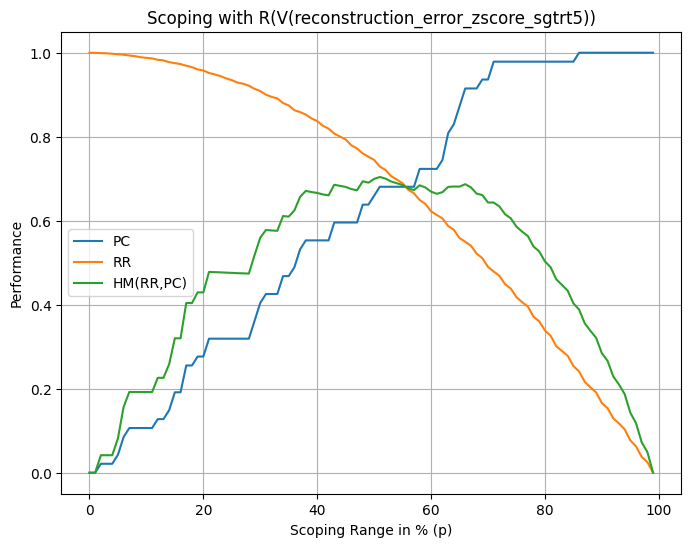

AUC PC (trapezoidal rule):  60.52127659574469
AUC HM (trapezoidal rule):  46.822966563472264


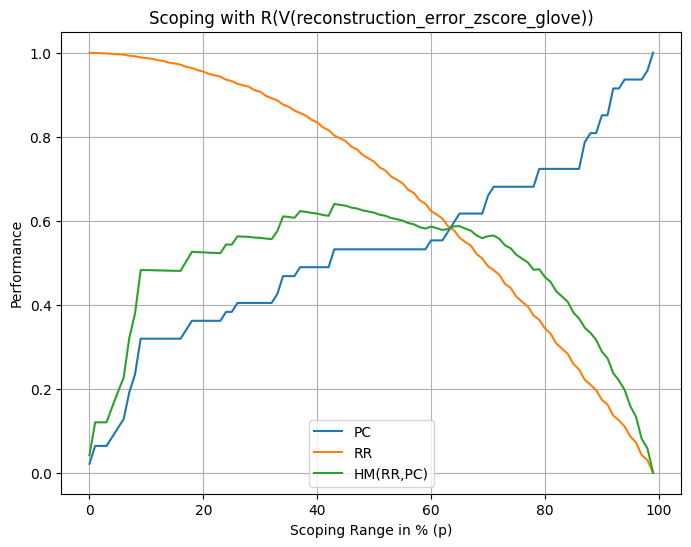

AUC PC (trapezoidal rule):  52.361702127659576
AUC HM (trapezoidal rule):  47.30204281040973


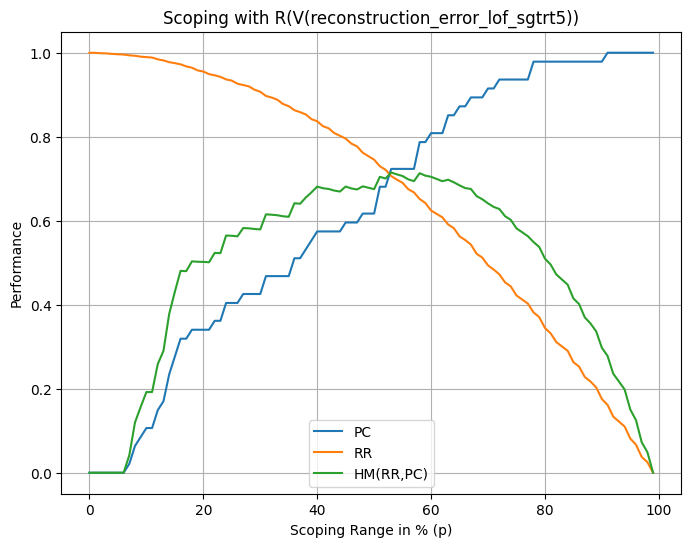

AUC PC (trapezoidal rule):  61.58510638297872
AUC HM (trapezoidal rule):  48.19251176198103


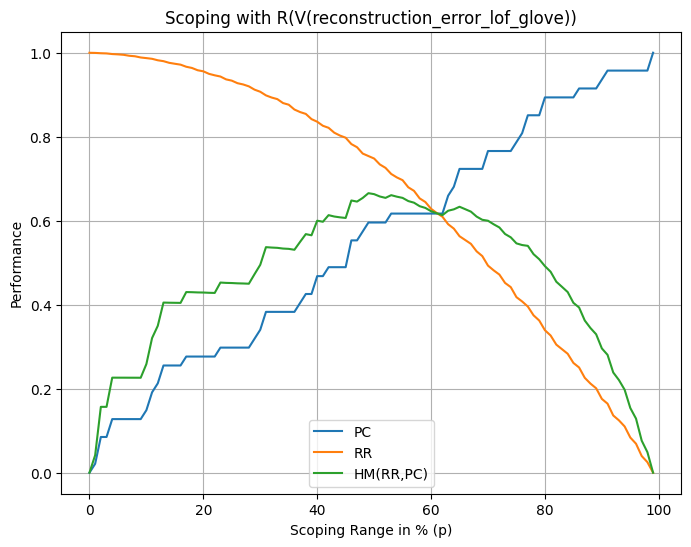

AUC PC (trapezoidal rule):  54.37234042553192
AUC HM (trapezoidal rule):  45.68637759938844


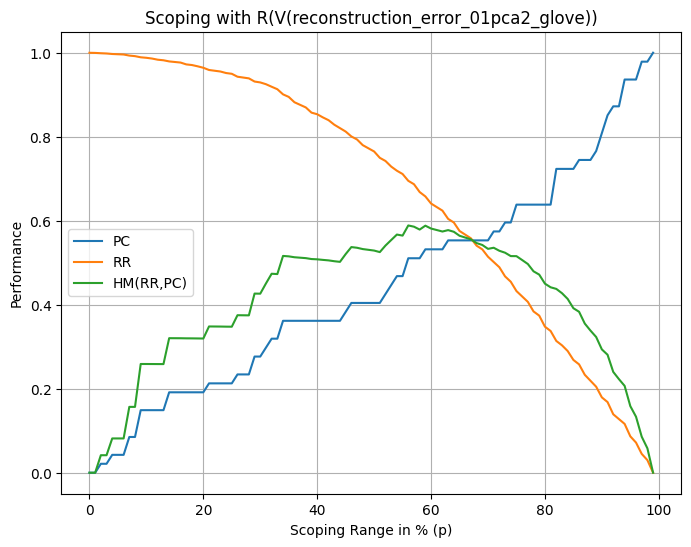

AUC PC (trapezoidal rule):  43.73404255319149
AUC HM (trapezoidal rule):  39.57387264561551


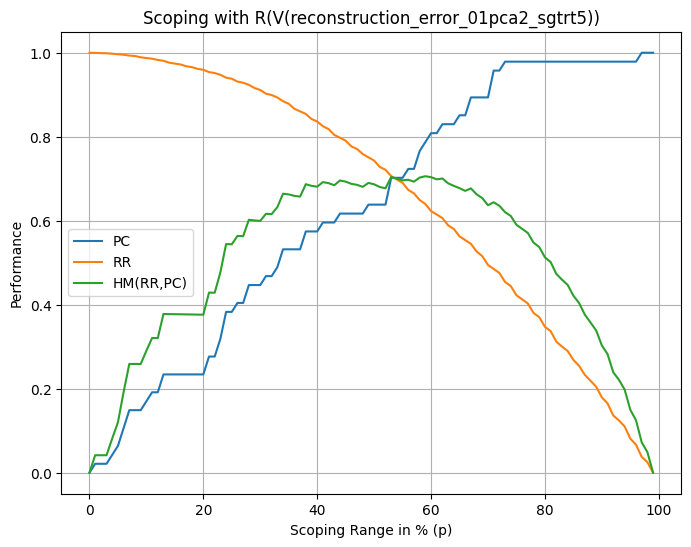

AUC PC (trapezoidal rule):  62.03191489361703
AUC HM (trapezoidal rule):  49.02383124491269


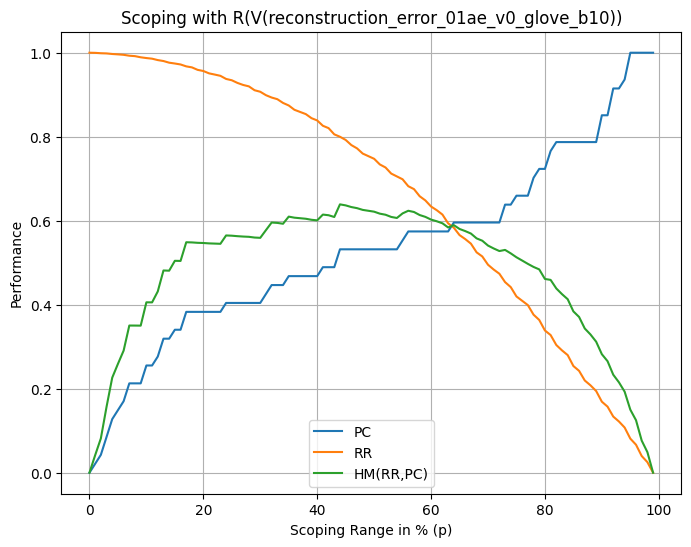

AUC PC (trapezoidal rule):  52.69148936170213
AUC HM (trapezoidal rule):  47.32972398467269


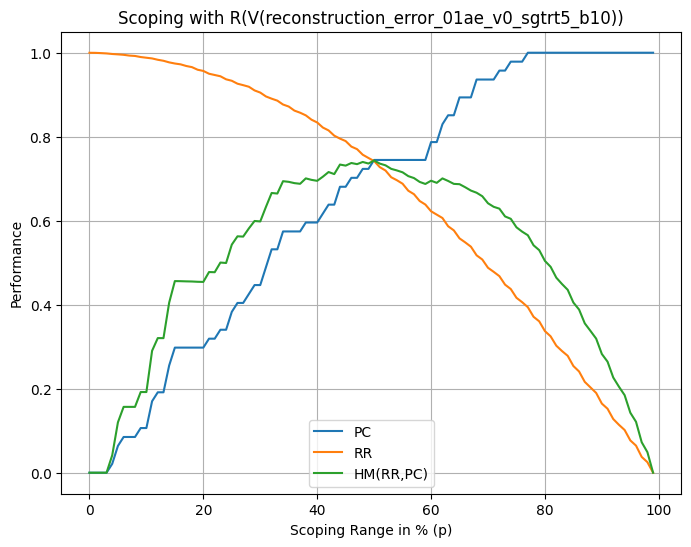

AUC PC (trapezoidal rule):  64.0531914893617
AUC HM (trapezoidal rule):  49.45416800039178


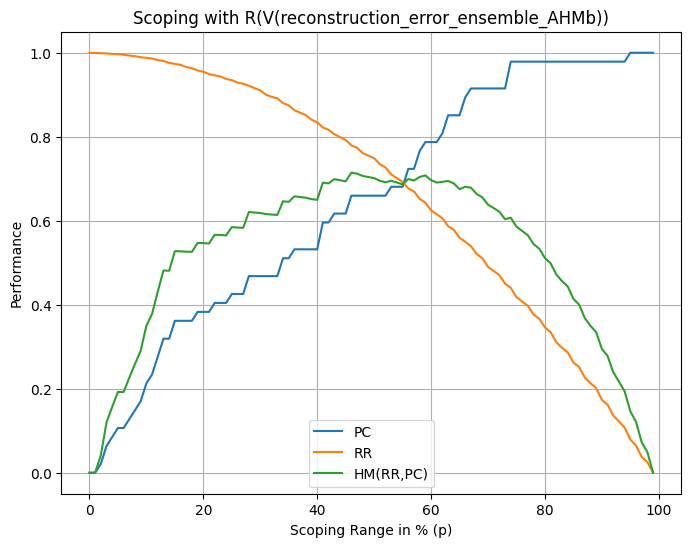

AUC PC (trapezoidal rule):  63.755319148936174
AUC HM (trapezoidal rule):  50.91910183000159


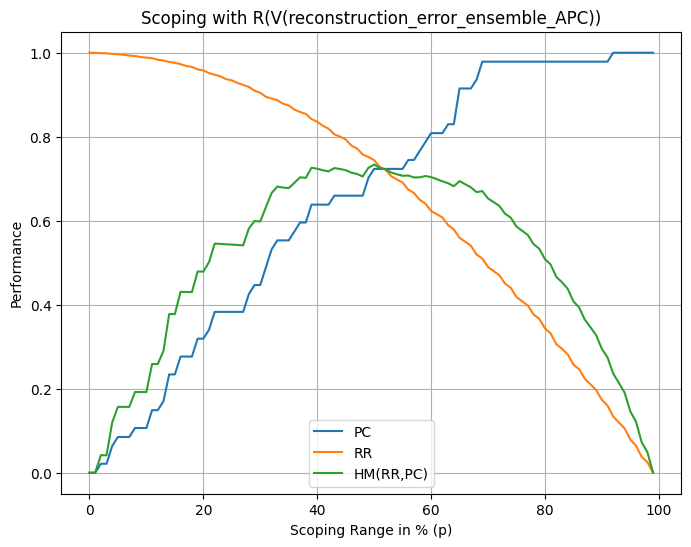

AUC PC (trapezoidal rule):  63.861702127659576
AUC HM (trapezoidal rule):  49.71412558537877


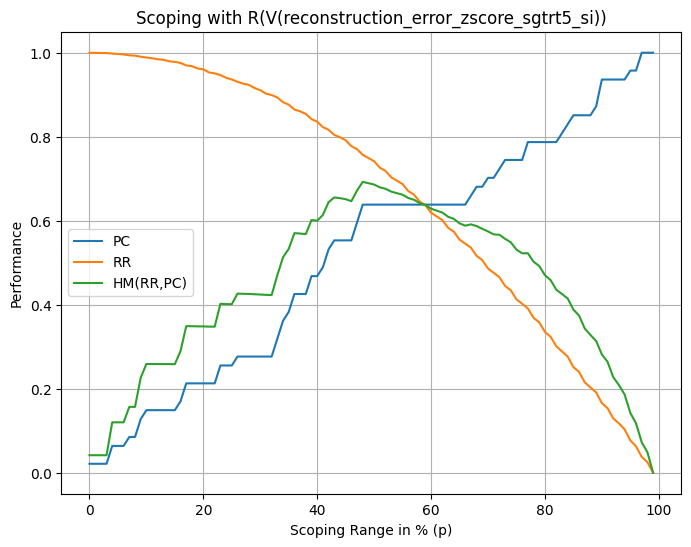

AUC PC (trapezoidal rule):  51.70212765957447
AUC HM (trapezoidal rule):  43.037523922199


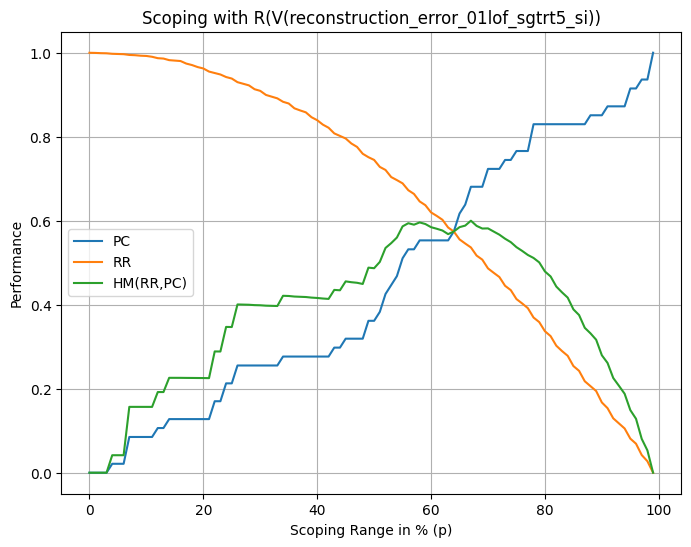

AUC PC (trapezoidal rule):  44.60638297872341
AUC HM (trapezoidal rule):  36.897814568454194


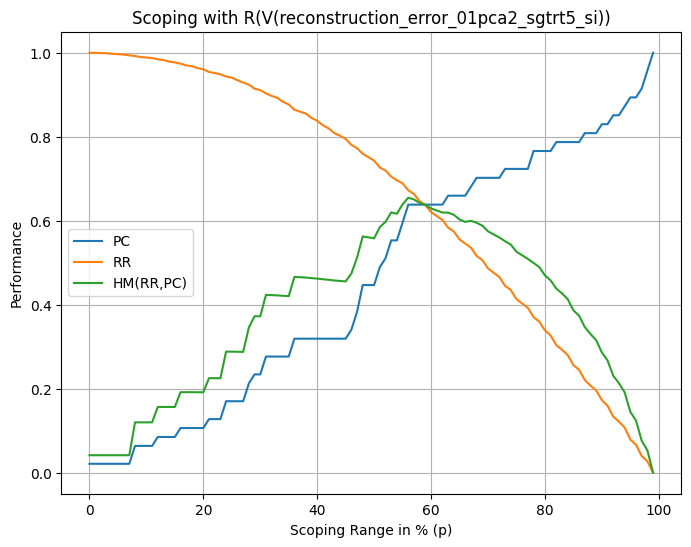

AUC PC (trapezoidal rule):  45.10638297872341
AUC HM (trapezoidal rule):  37.30479852563676


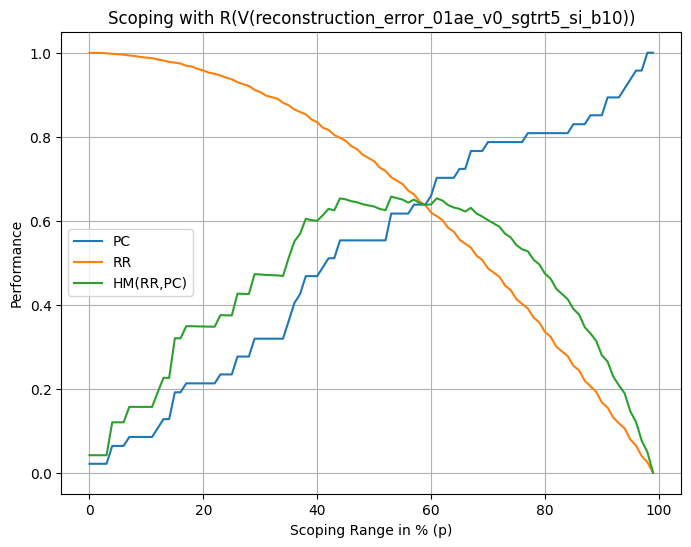

AUC PC (trapezoidal rule):  51.808510638297875
AUC HM (trapezoidal rule):  42.85034413900394


Setting  AUC_PC_trapezoidal  \
0           reconstruction_error_zscore_sgtrt5           60.521277   
1            reconstruction_error_zscore_glove           52.361702   
2              reconstruction_error_lof_sgtrt5           61.585106   
3               reconstruction_error_lof_glove           54.372340   
4            reconstruction_error_01pca2_glove           43.734043   
5           reconstruction_error_01pca2_sgtrt5           62.031915   
6       reconstruction_error_01ae_v0_glove_b10           52.691489   
7      reconstruction_error_01ae_v0_sgtrt5_b10           64.053191   
8           reconstruction_error_ensemble_AHMb           63.755319   
9            reconstruction_error_ensemble_APC           63.861702   
10       reconstruction_error_zscore_sgtrt5_si           51.702128   
11        reconstruction_error_01lof_sgtrt5_si           44.606383   
12       reconstruction_error_01pca2_sgtrt5_si           45.106383   
13  reconstruction_error_01ae_v0_sgtrt5_si_b10           51.808511   

    AUC_HM_trapezoidal  
0            46.822967  
1            47.302043  
2            48.192512  
3            45.686378  
4            39.573873  
5            49.023831  
6            47.329724  
7            49.454168  
8            50.919102  
9            49.714126  
10           43.037524  
11           36.897815  
12           37.304799  
13           42.850344

In [ ]:
auc = []
for eval_col in df_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("reconstruction_error")]:
  auc.append(performance_plot(df_OC_ORACLE_OC_MYSQL_OC_HANA, eval_col, gt_id_OC_ORACLE_OC_MYSQL_OC_HANA))
pd.DataFrame(auc, columns=["Setting", "AUC_PC_trapezoidal", "AUC_HM_trapezoidal"])

## LSH

In [ ]:
#ce_OC_ORACLE_OC_MYSQL_OC_HANA Glove_s gtrt5_si gtrt5_s

In [201]:
def get_signature_variant_from_method(method_string):
    if("sgtrt5_si" in method_string):
        return "gtrt5_si"
    elif("sgtrt5" in method_string):
        return "gtrt5_s"
    elif("glove" in method_string):
        return "Glove_s"
    else:
        return "gtrt5_s"

In [233]:
df_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("reconstruction_error")]

Index(['reconstruction_error_zscore_sgtrt5',
       'reconstruction_error_zscore_glove', 'reconstruction_error_lof_sgtrt5',
       'reconstruction_error_lof_glove', 'reconstruction_error_01pca2_glove',
       'reconstruction_error_01pca2_sgtrt5',
       'reconstruction_error_01ae_v0_glove_b10',
       'reconstruction_error_01ae_v0_sgtrt5_b10',
       'reconstruction_error_ensemble_AHMb',
       'reconstruction_error_ensemble_APC',
       'reconstruction_error_zscore_sgtrt5_si',
       'reconstruction_error_01lof_sgtrt5_si',
       'reconstruction_error_01pca2_sgtrt5_si',
       'reconstruction_error_01ae_v0_sgtrt5_si_b10'],
      dtype='object')

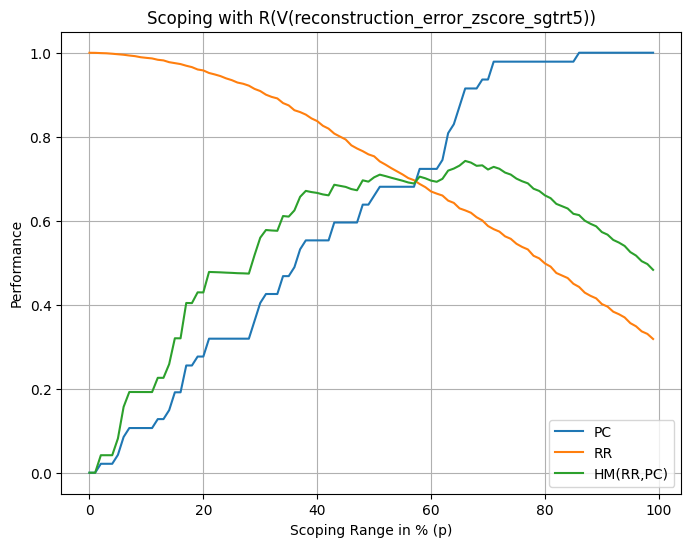

AUC PC (trapezoidal rule):  60.52127659574469
AUC HM (trapezoidal rule):  54.10529022881965


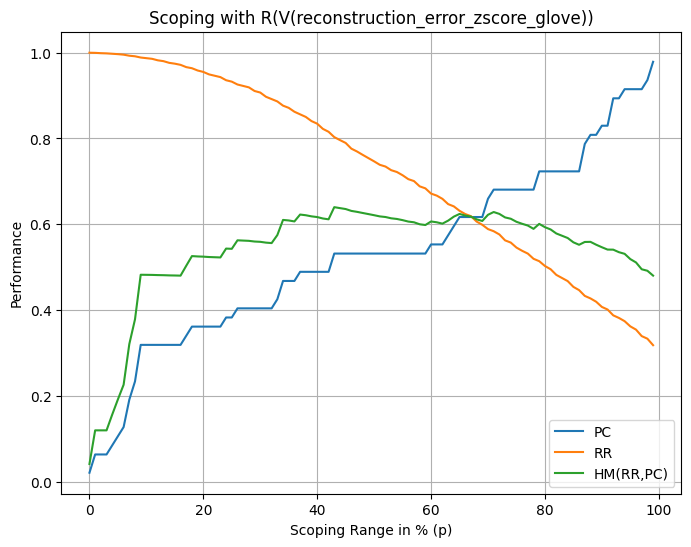

AUC PC (trapezoidal rule):  52.15957446808511
AUC HM (trapezoidal rule):  53.653701539730896


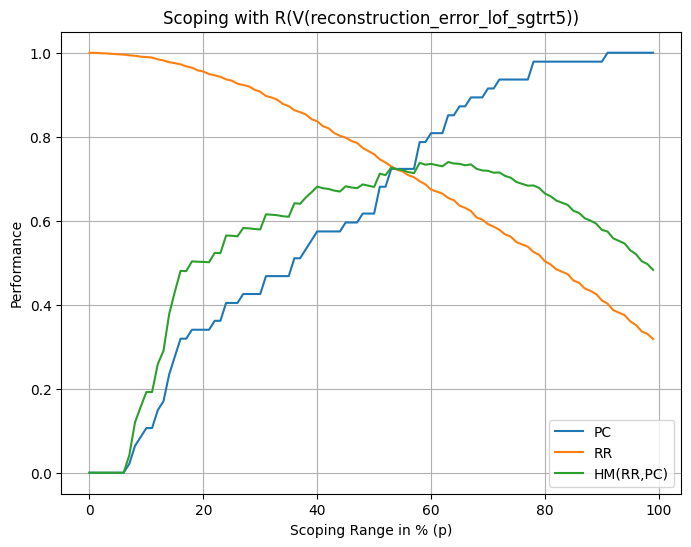

AUC PC (trapezoidal rule):  61.58510638297872
AUC HM (trapezoidal rule):  55.40702916244529


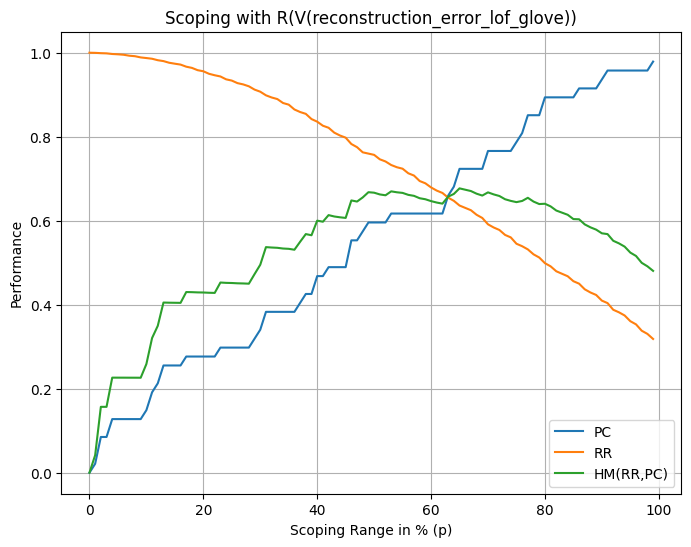

AUC PC (trapezoidal rule):  54.361702127659576
AUC HM (trapezoidal rule):  52.523979356182245


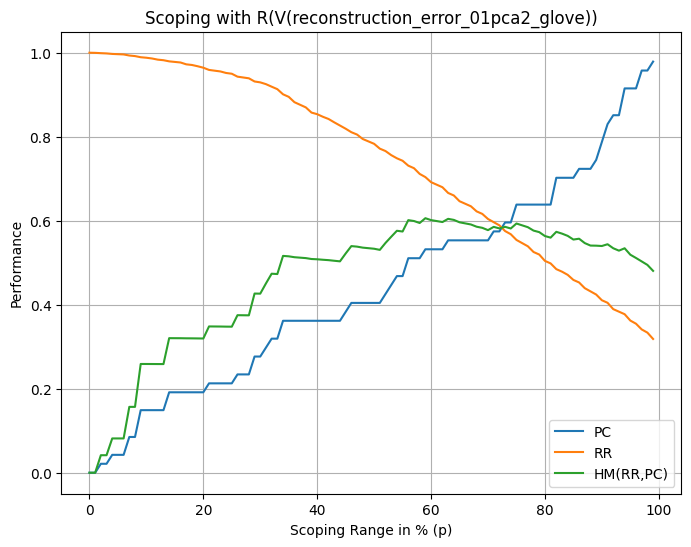

AUC PC (trapezoidal rule):  43.36170212765958
AUC HM (trapezoidal rule):  45.58732361886129


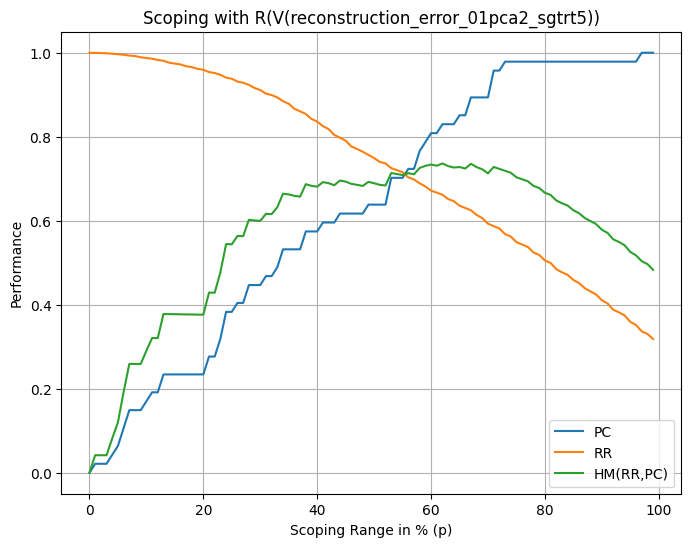

AUC PC (trapezoidal rule):  62.03191489361703
AUC HM (trapezoidal rule):  56.155067992160745


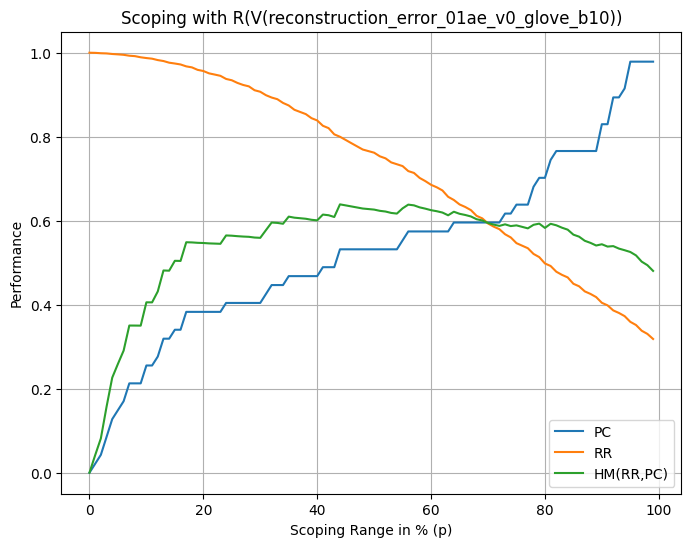

AUC PC (trapezoidal rule):  52.12765957446808
AUC HM (trapezoidal rule):  53.68239863004923


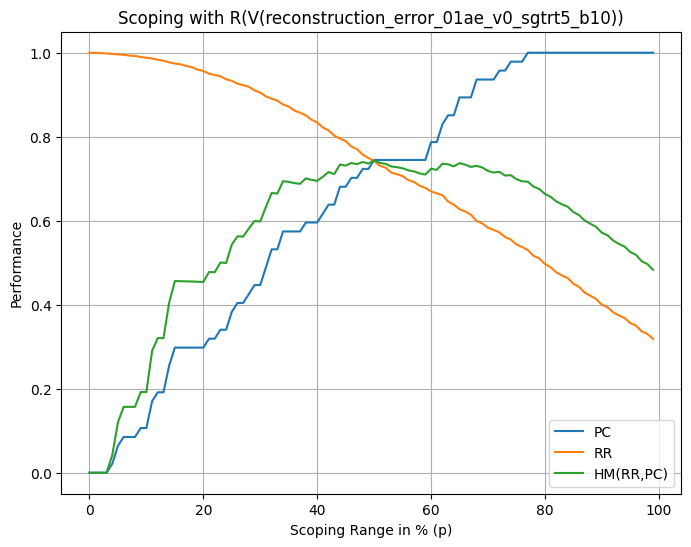

AUC PC (trapezoidal rule):  64.0531914893617
AUC HM (trapezoidal rule):  56.729516231142625


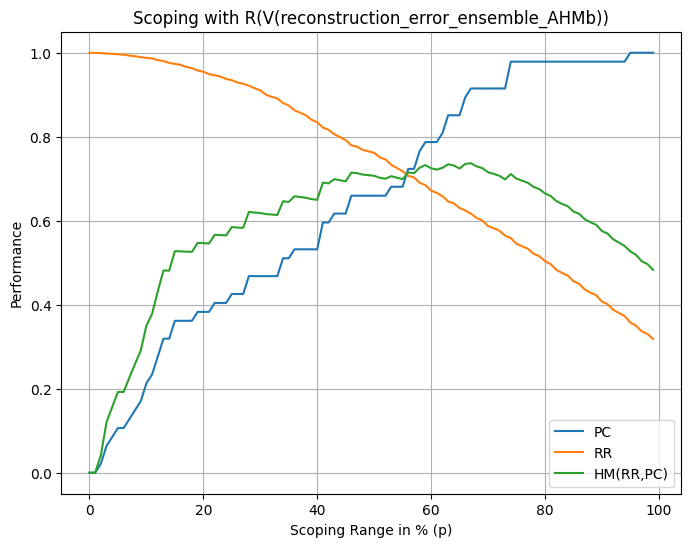

AUC PC (trapezoidal rule):  63.755319148936174
AUC HM (trapezoidal rule):  58.1052182463909


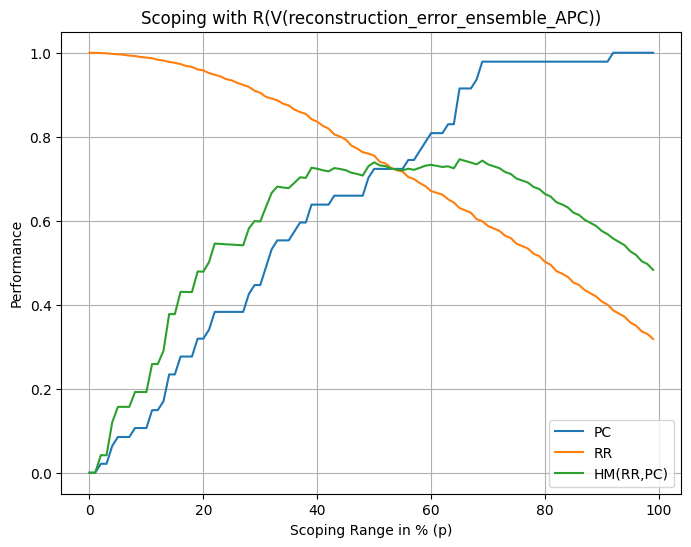

AUC PC (trapezoidal rule):  63.861702127659576
AUC HM (trapezoidal rule):  56.96689295221608


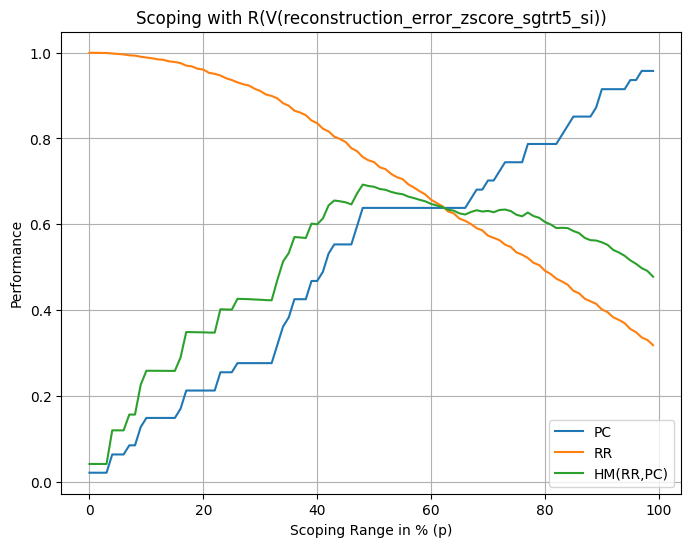

AUC PC (trapezoidal rule):  51.4468085106383
AUC HM (trapezoidal rule):  49.60676665854751


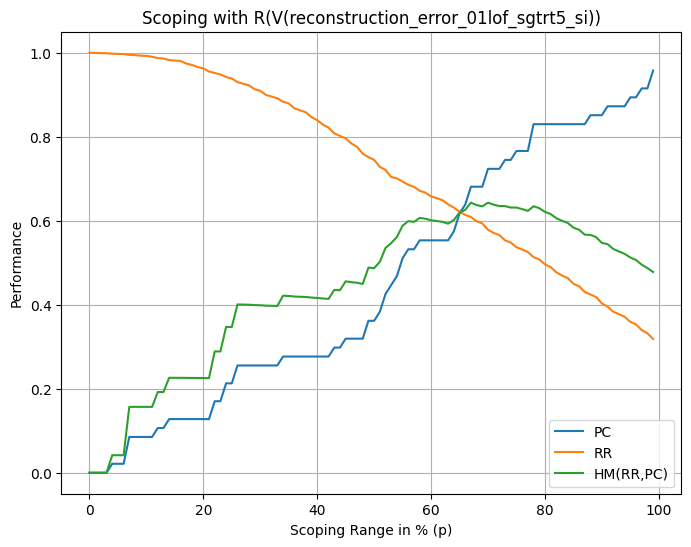

AUC PC (trapezoidal rule):  44.50000000000001
AUC HM (trapezoidal rule):  43.40043992776699


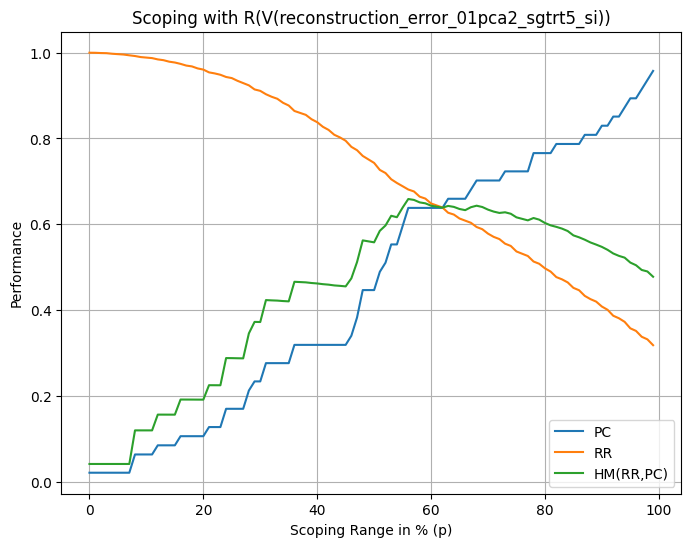

AUC PC (trapezoidal rule):  45.06382978723405
AUC HM (trapezoidal rule):  43.661248922275846


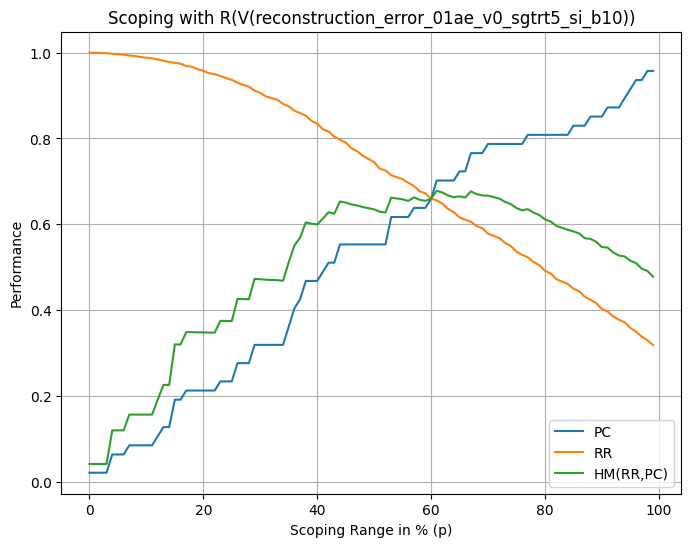

AUC PC (trapezoidal rule):  51.59574468085107
AUC HM (trapezoidal rule):  49.478856698240136


Setting  AUC_PC_trapezoidal  \
0           reconstruction_error_zscore_sgtrt5           60.521277   
1            reconstruction_error_zscore_glove           52.159574   
2              reconstruction_error_lof_sgtrt5           61.585106   
3               reconstruction_error_lof_glove           54.361702   
4            reconstruction_error_01pca2_glove           43.361702   
5           reconstruction_error_01pca2_sgtrt5           62.031915   
6       reconstruction_error_01ae_v0_glove_b10           52.127660   
7      reconstruction_error_01ae_v0_sgtrt5_b10           64.053191   
8           reconstruction_error_ensemble_AHMb           63.755319   
9            reconstruction_error_ensemble_APC           63.861702   
10       reconstruction_error_zscore_sgtrt5_si           51.446809   
11        reconstruction_error_01lof_sgtrt5_si           44.500000   
12       reconstruction_error_01pca2_sgtrt5_si           45.063830   
13  reconstruction_error_01ae_v0_sgtrt5_si_b10           51.595745   

    AUC_HM_trapezoidal  
0            54.105290  
1            53.653702  
2            55.407029  
3            52.523979  
4            45.587324  
5            56.155068  
6            53.682399  
7            56.729516  
8            58.105218  
9            56.966893  
10           49.606767  
11           43.400440  
12           43.661249  
13           49.478857

In [278]:
auc = []
for eval_col in df_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("reconstruction_error")]:
  #print(get_signature_variant_from_method(eval_col))
  auc.append(performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA,
                                  ce_OC_ORACLE_OC_MYSQL_OC_HANA,
                                  eval_col,
                                  gt_id_OC_ORACLE_OC_MYSQL_OC_HANA, k=50,
                                  signature_variant=get_signature_variant_from_method(eval_col)))
pd.DataFrame(auc, columns=["Setting", "AUC_PC_trapezoidal", "AUC_HM_trapezoidal"])

## Ensemble

In [ ]:
scaler = MinMaxScaler()

In [ ]:
ensemble = df_OC_ORACLE_OC_MYSQL_OC_HANA[["reconstruction_error_zscore_glove","reconstruction_error_lof_sgtrt5","reconstruction_error_pca2_sgtrt5","reconstruction_error_01ae_v0_sgtrt5_b10"]].copy()
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_ensemble_AHMb"] = pd.DataFrame(scaler.fit_transform(ensemble), columns=ensemble.columns).mean(axis=1)

In [ ]:
ensemble = df_OC_ORACLE_OC_MYSQL_OC_HANA[["reconstruction_error_zscore_sgtrt5","reconstruction_error_lof_sgtrt5","reconstruction_error_pca2_sgtrt5","reconstruction_error_01ae_v0_sgtrt5_b10"]].copy()
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_ensemble_APC"] = pd.DataFrame(scaler.fit_transform(ensemble), columns=ensemble.columns).mean(axis=1)

## Source Participation

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA.columns

Index(['id', 'refined_local_name', 'parent_id', 'refined_local_name_p',
       'schema', 'vec_datatype_numeric', 'vec_datatype_text',
       'vec_datatype_date', 'vec_datatype_miscellaneous', 'vec_constraint_pk',
       'vec_constraint_fk', 'vec_constraint_notnull', 'vec_constraint_default',
       'vec_constraint_unique', 'vec_constaint_check', 'concept_concat_info',
       'concept_concat_sgtrt5', 'reconstruction_error_zscore_sgtrt5',
       'reconstruction_error_zscore_glove', 'reconstruction_error_lof_sgtrt5',
       'reconstruction_error_lof_glove', 'reconstruction_error_01pca2_glove',
       'reconstruction_error_01pca2_sgtrt5',
       'reconstruction_error_01ae_v0_glove_b10',
       'reconstruction_error_01ae_v0_sgtrt5_b10',
       'reconstruction_error_ensemble_AHMb',
       'reconstruction_error_ensemble_APC',
       'concept_concat_schema_instances_sgtrt5',
       'reconstruction_error_zscore_sgtrt5_si',
       'reconstruction_error_01lof_sgtrt5_si',
       'reconstruction_er

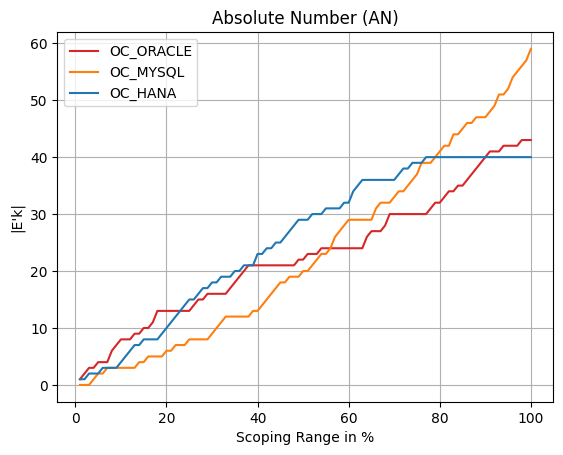

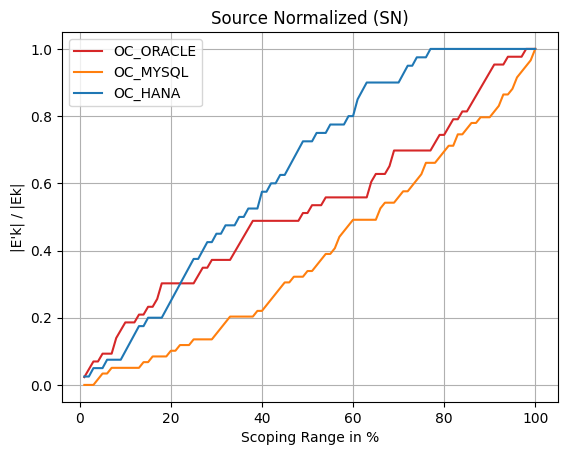

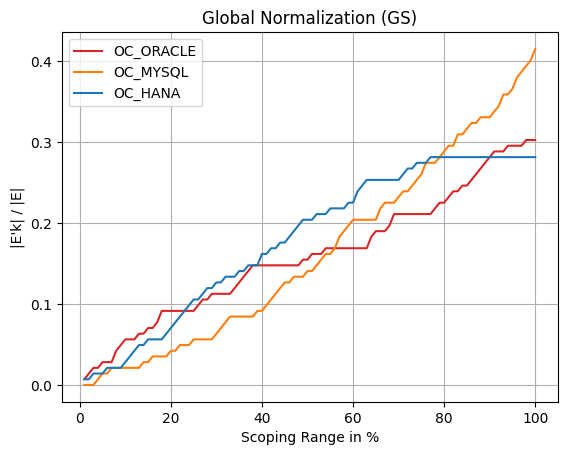

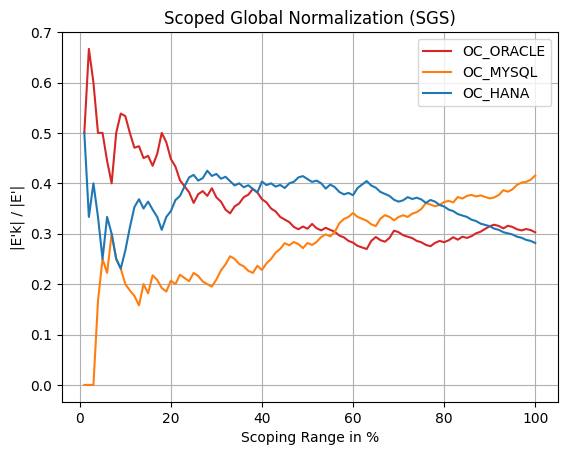

In [ ]:
source_participation_absolute(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_sgtrt5_b10", 1)
source_participation_local_relative(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_sgtrt5_b10", 1)
source_participation_global_relative(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_sgtrt5_b10", 1)
source_participation_scoped_global_relative(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_sgtrt5_b10", 1)

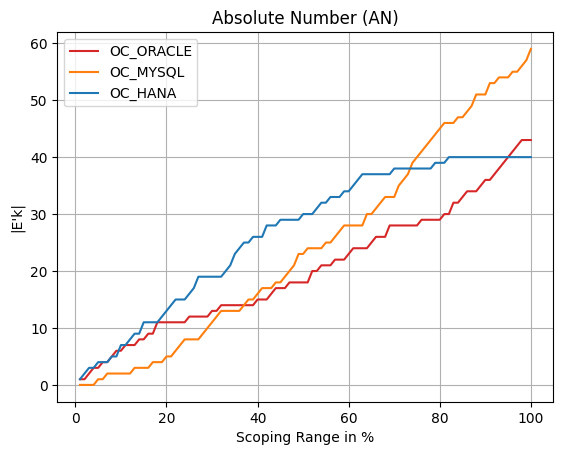

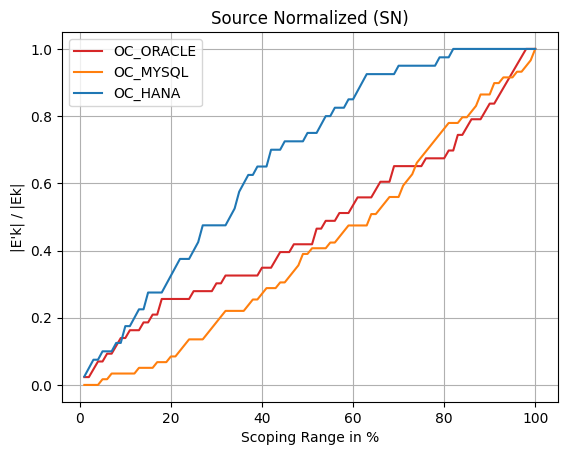

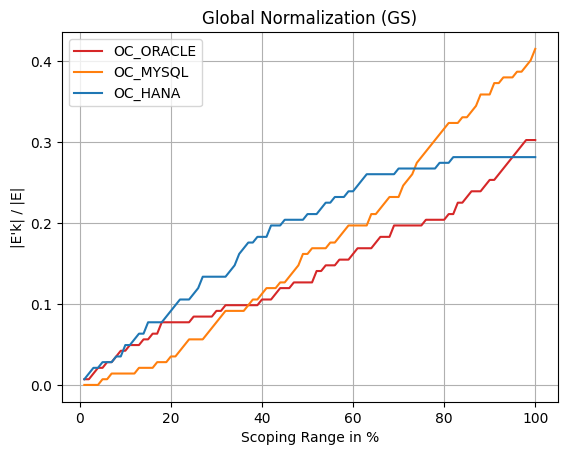

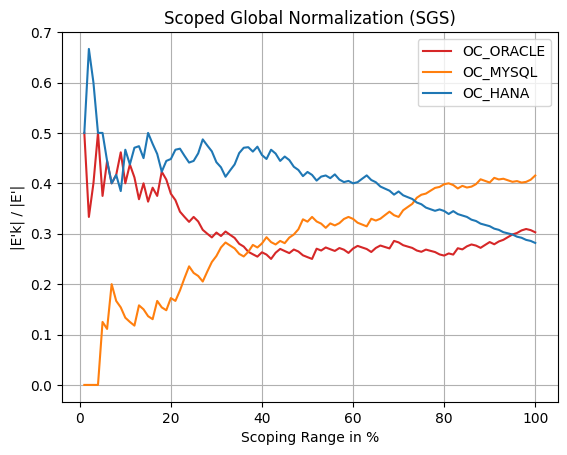

In [ ]:
source_participation_absolute(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", 1)
source_participation_local_relative(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", 1)
source_participation_global_relative(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", 1)
source_participation_scoped_global_relative(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", 1)

# 2.3 Scoping Evaluation (OC3-HR: domain-agnostic)

In [204]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = pd.read_csv(r'https://raw.githubusercontent.com/leotraeg/scoping/main/datasets_OC3HR/df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.csv')

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_sgtrt5"] = method_zscore(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"))
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_glove"] =  method_zscore(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"))
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_sgtrt5_si"] = method_zscore(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_si"))

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_sgtrt5"] = method_clf(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), min_max_scale=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_glove"] =  method_clf(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"), min_max_scale=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_sgtrt5_si"] = method_clf(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_si"), min_max_scale=True)

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_glove"],_ = method_pca(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), 2, min_max_scale=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_sgtrt5"],_ = method_pca(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), 2, min_max_scale=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_sgtrt5_si"],_ = method_pca(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_si"), 2, min_max_scale=True)

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=20, bottleneck=10)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=20, bottleneck=10)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_si_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_si"), max_iter=20, bottleneck=10)

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns

Index(['id', 'refined_local_name', 'parent_id', 'refined_local_name_p',
       'schema', 'vec_datatype_numeric', 'vec_datatype_text',
       'vec_datatype_date', 'vec_datatype_miscellaneous', 'vec_constraint_pk',
       'vec_constraint_fk', 'vec_constraint_notnull', 'vec_constraint_default',
       'vec_constraint_unique', 'vec_constaint_check', 'concept_concat_info',
       'concept_concat_sgtrt5', 'concept_concat_sgtrt5_dtype_constraints',
       'reconstruction_error_zscore_sgtrt5',
       'reconstruction_error_zscore_glove',
       'reconstruction_error_01lof_sgtrt5', 'reconstruction_error_01lof_glove',
       'reconstruction_error_01pca2_glove',
       'reconstruction_error_01pca2_sgtrt5',
       'reconstruction_error_01ae_v0_glove_b10',
       'reconstruction_error_01ae_v0_sgtrt5_b10',
       'reconstruction_error_ensemble_AHMb',
       'reconstruction_error_ensemble_APC',
       'concept_concat_schema_instances_sgtrt5',
       'reconstruction_error_zscore_sgtrt5_si',
       'rec

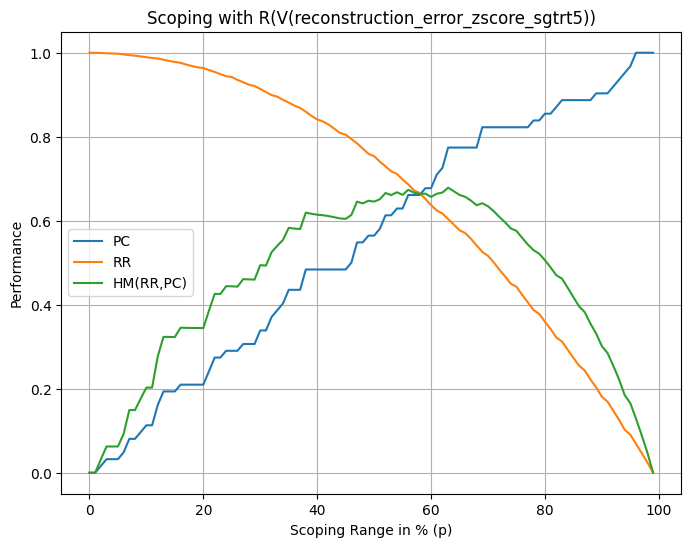

AUC PC (trapezoidal rule):  54.20967741935483
AUC HM (trapezoidal rule):  44.81237377128327


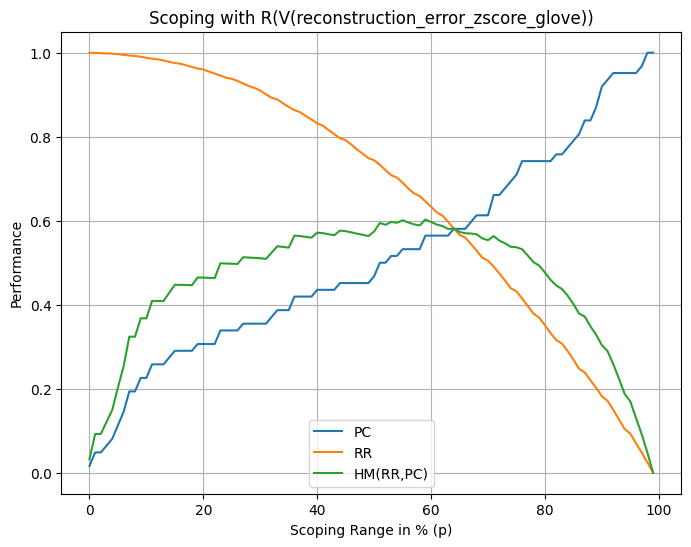

AUC PC (trapezoidal rule):  50.57258064516129
AUC HM (trapezoidal rule):  45.05666889092153


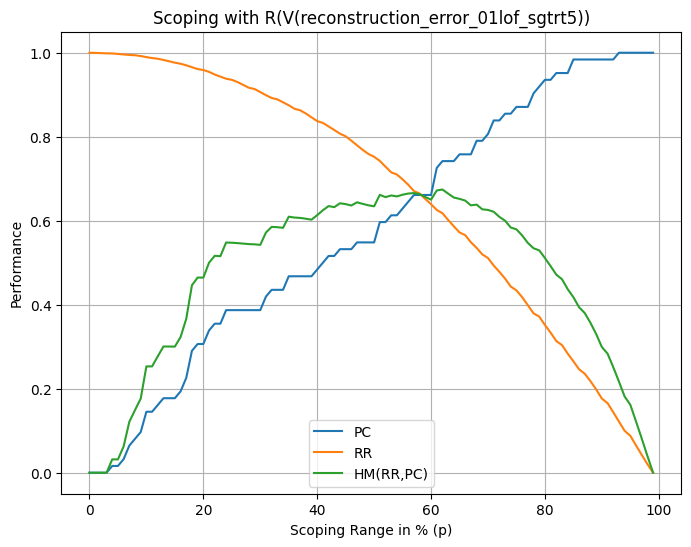

AUC PC (trapezoidal rule):  57.11290322580645
AUC HM (trapezoidal rule):  46.157600710834494


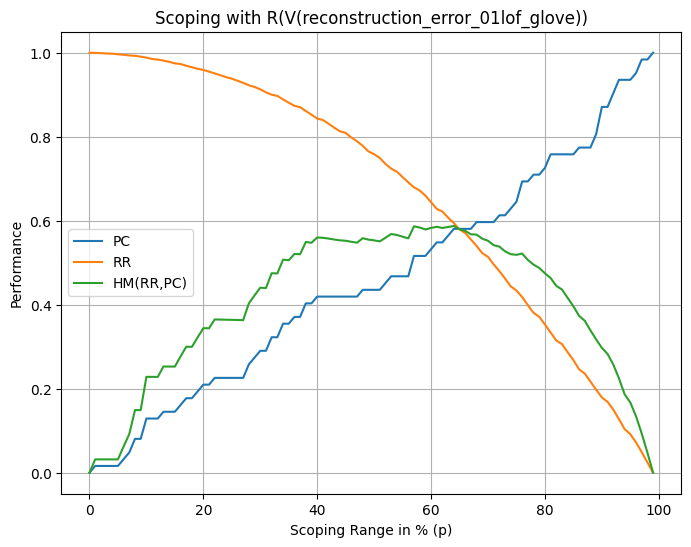

AUC PC (trapezoidal rule):  45.33870967741935
AUC HM (trapezoidal rule):  39.846020583209636


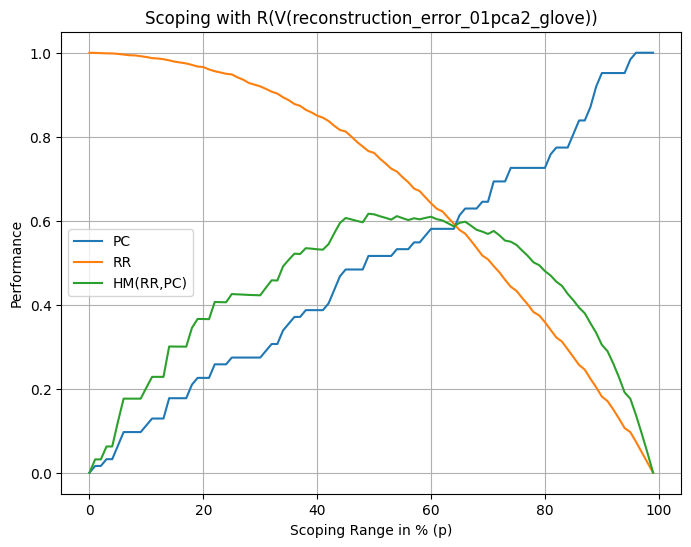

AUC PC (trapezoidal rule):  48.48387096774193
AUC HM (trapezoidal rule):  41.833745251881716


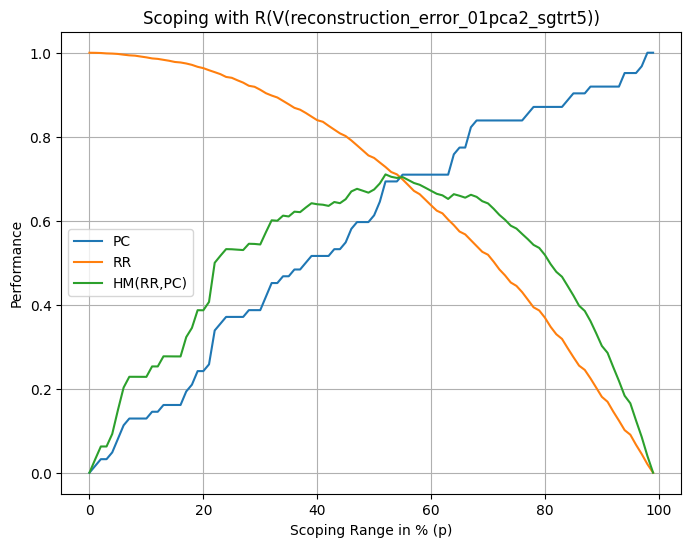

AUC PC (trapezoidal rule):  56.9516129032258
AUC HM (trapezoidal rule):  47.137888994749545


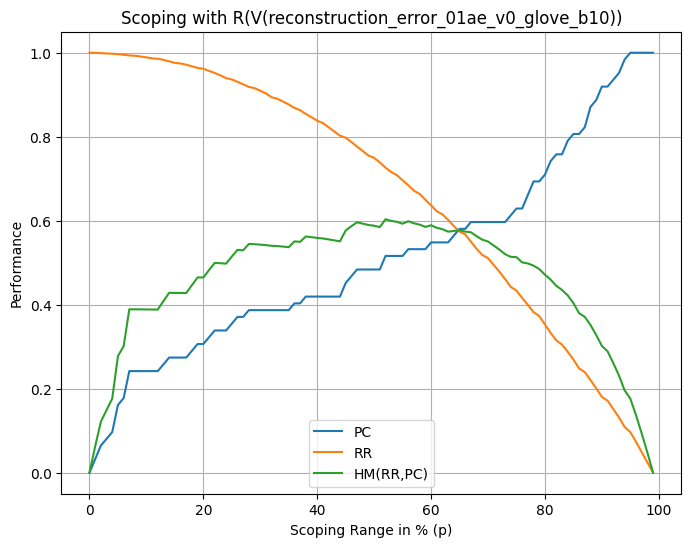

AUC PC (trapezoidal rule):  50.306451612903224
AUC HM (trapezoidal rule):  45.37329871552734


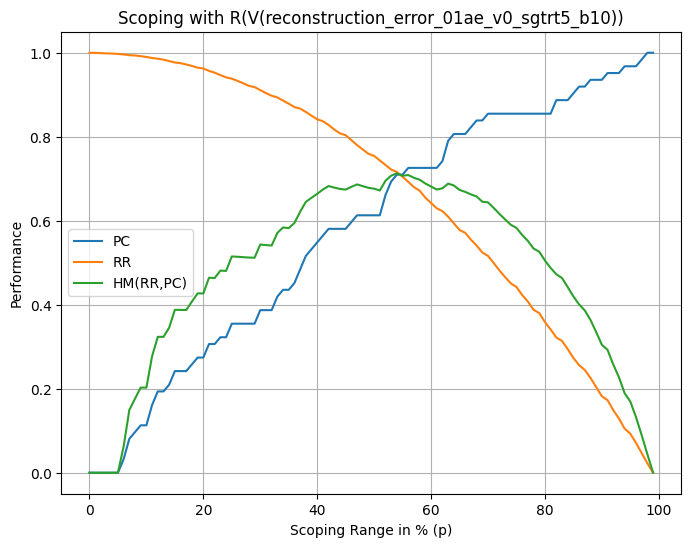

AUC PC (trapezoidal rule):  57.58064516129032
AUC HM (trapezoidal rule):  47.1089042636014


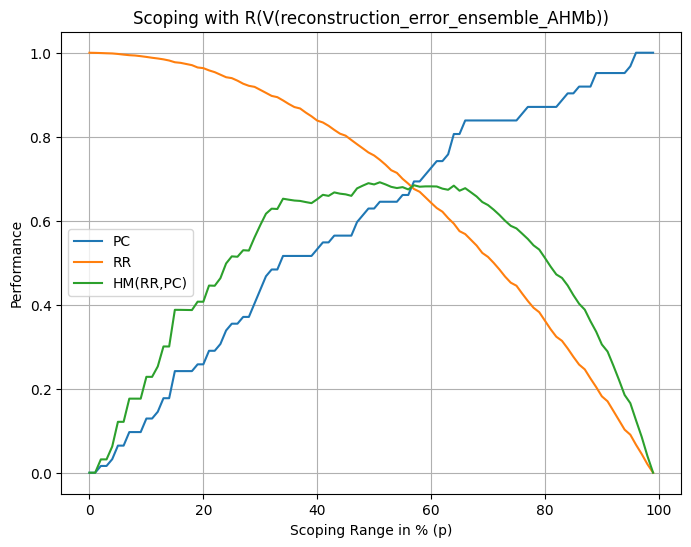

AUC PC (trapezoidal rule):  57.806451612903224
AUC HM (trapezoidal rule):  47.4469268914215


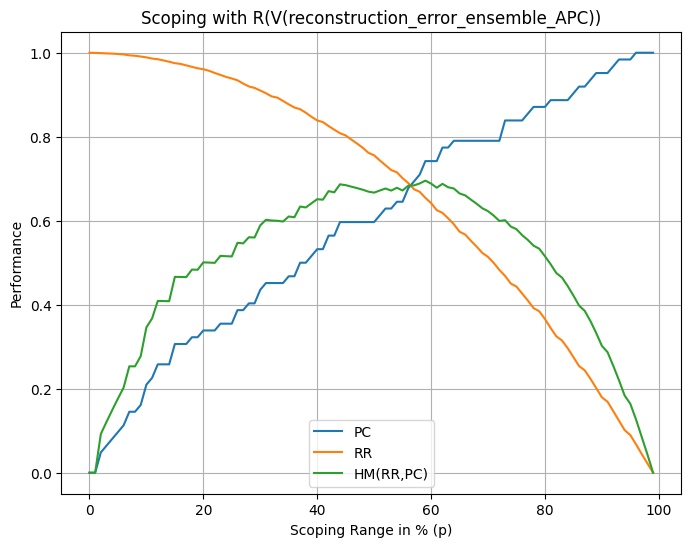

AUC PC (trapezoidal rule):  58.806451612903224
AUC HM (trapezoidal rule):  49.12560418463047


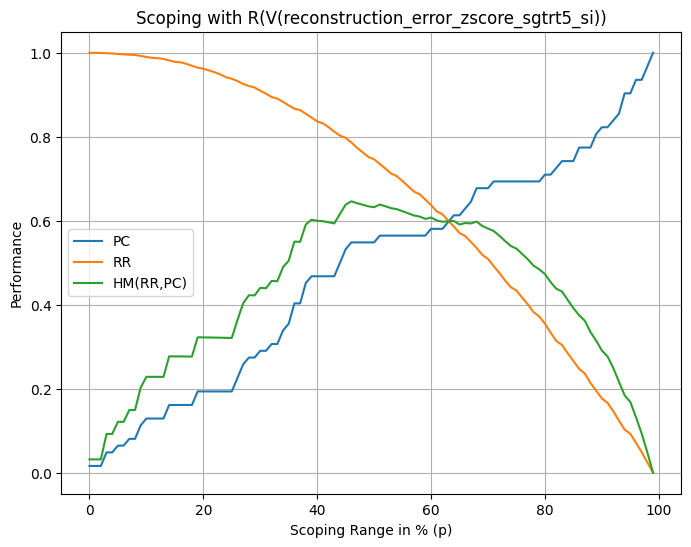

AUC PC (trapezoidal rule):  47.685483870967744
AUC HM (trapezoidal rule):  41.647553396010956


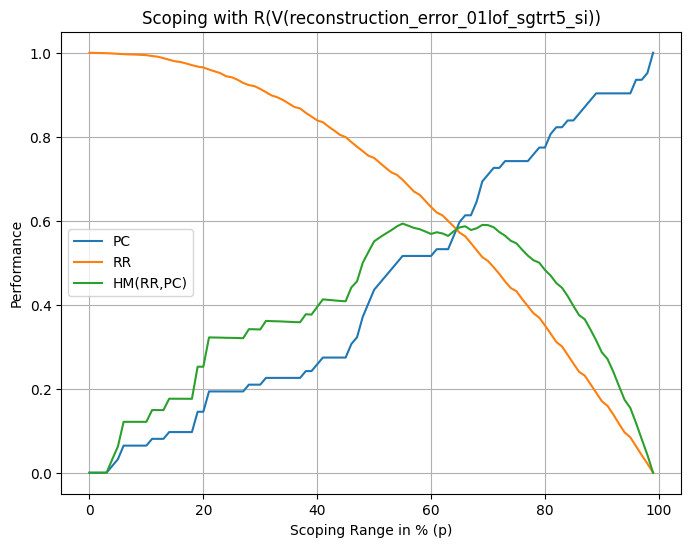

AUC PC (trapezoidal rule):  43.79032258064517
AUC HM (trapezoidal rule):  36.07539554921908


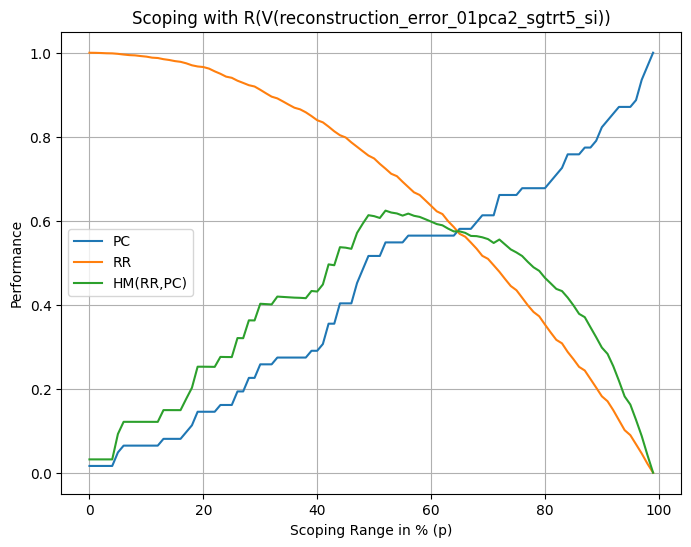

AUC PC (trapezoidal rule):  43.362903225806456
AUC HM (trapezoidal rule):  37.471676366852556


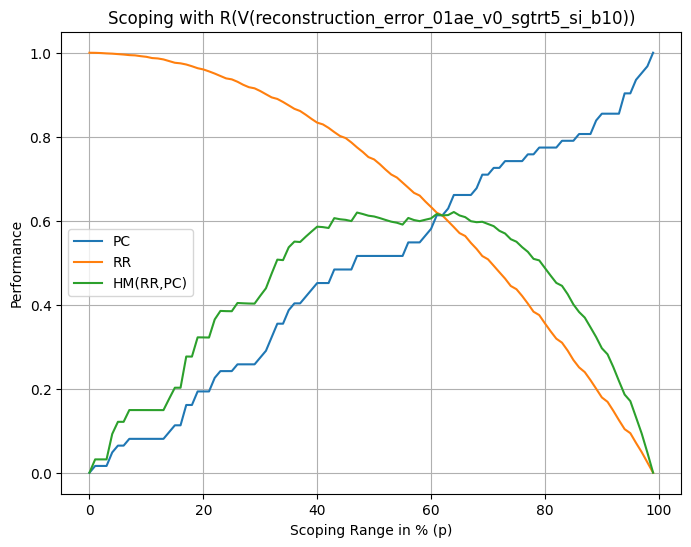

AUC PC (trapezoidal rule):  48.20967741935484
AUC HM (trapezoidal rule):  41.220789050193225


Setting  AUC_PC_trapezoidal  \
0           reconstruction_error_zscore_sgtrt5           54.209677   
1            reconstruction_error_zscore_glove           50.572581   
2            reconstruction_error_01lof_sgtrt5           57.112903   
3             reconstruction_error_01lof_glove           45.338710   
4            reconstruction_error_01pca2_glove           48.483871   
5           reconstruction_error_01pca2_sgtrt5           56.951613   
6       reconstruction_error_01ae_v0_glove_b10           50.306452   
7      reconstruction_error_01ae_v0_sgtrt5_b10           57.580645   
8           reconstruction_error_ensemble_AHMb           57.806452   
9            reconstruction_error_ensemble_APC           58.806452   
10       reconstruction_error_zscore_sgtrt5_si           47.685484   
11        reconstruction_error_01lof_sgtrt5_si           43.790323   
12       reconstruction_error_01pca2_sgtrt5_si           43.362903   
13  reconstruction_error_01ae_v0_sgtrt5_si_b10           48.209677   

    AUC_HM_trapezoidal  
0            44.812374  
1            45.056669  
2            46.157601  
3            39.846021  
4            41.833745  
5            47.137889  
6            45.373299  
7            47.108904  
8            47.446927  
9            49.125604  
10           41.647553  
11           36.075396  
12           37.471676  
13           41.220789

In [ ]:
auc = []
for eval_col in df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("reconstruction_error")]:
  auc.append(performance_plot(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, eval_col, gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA))
pd.DataFrame(auc, columns=["Setting", "AUC_PC_trapezoidal", "AUC_HM_trapezoidal"])

## Ensemble

In [ ]:
scaler = MinMaxScaler()

In [ ]:
ensemble = df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[["reconstruction_error_zscore_glove","reconstruction_error_lof_sgtrt5","reconstruction_error_pca2_sgtrt5","reconstruction_error_01ae_v0_sgtrt5_b10"]].copy()
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_ensemble_APC"] = pd.DataFrame(scaler.fit_transform(ensemble), columns=ensemble.columns).mean(axis=1)

In [ ]:
ensemble = df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[["reconstruction_error_zscore_sgtrt5","reconstruction_error_lof_sgtrt5","reconstruction_error_pca2_sgtrt5","reconstruction_error_01ae_v0_sgtrt5_b10"]].copy()
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_ensemble_AHMb"] = pd.DataFrame(scaler.fit_transform(ensemble), columns=ensemble.columns).mean(axis=1)

## LSH

In [ ]:
#ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA Glove_s gtrt5_si gtrt5_s

In [240]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("reconstruction_error")]

Index(['reconstruction_error_zscore_sgtrt5',
       'reconstruction_error_zscore_glove',
       'reconstruction_error_01lof_sgtrt5', 'reconstruction_error_01lof_glove',
       'reconstruction_error_01pca2_glove',
       'reconstruction_error_01pca2_sgtrt5',
       'reconstruction_error_01ae_v0_glove_b10',
       'reconstruction_error_01ae_v0_sgtrt5_b10',
       'reconstruction_error_ensemble_AHMb',
       'reconstruction_error_ensemble_APC',
       'reconstruction_error_zscore_sgtrt5_si',
       'reconstruction_error_01lof_sgtrt5_si',
       'reconstruction_error_01pca2_sgtrt5_si',
       'reconstruction_error_01ae_v0_sgtrt5_si_b10'],
      dtype='object')

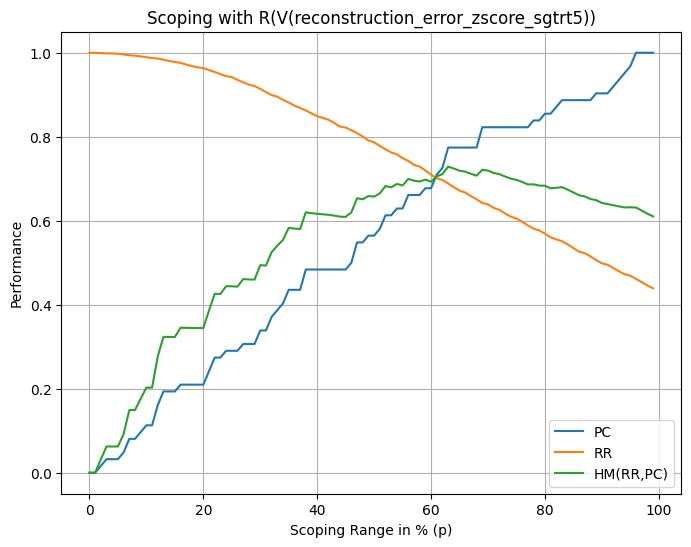

AUC PC (trapezoidal rule):  54.20967741935483
AUC HM (trapezoidal rule):  53.61285623135502


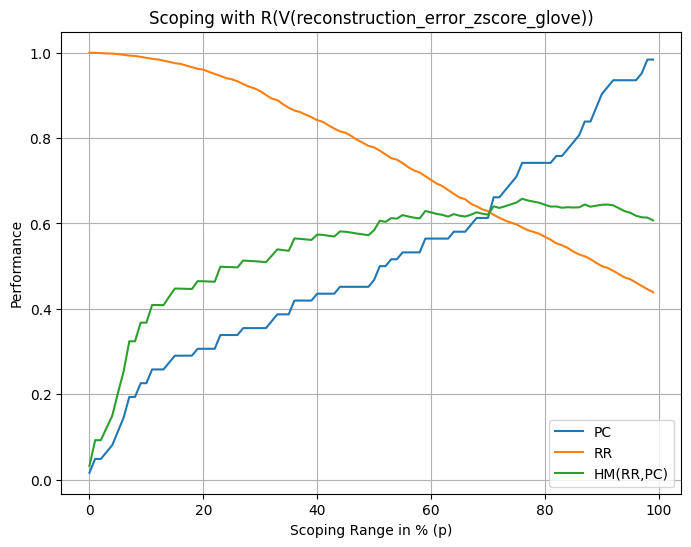

AUC PC (trapezoidal rule):  50.41935483870968
AUC HM (trapezoidal rule):  53.428324285704925


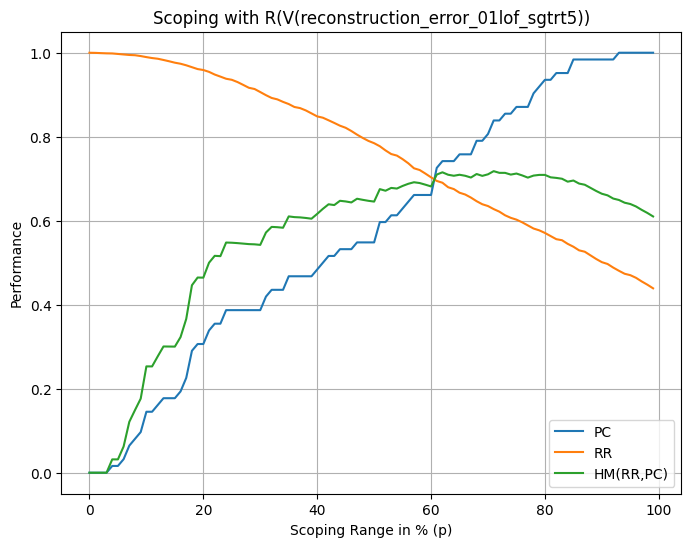

AUC PC (trapezoidal rule):  57.11290322580645
AUC HM (trapezoidal rule):  55.413674440175676


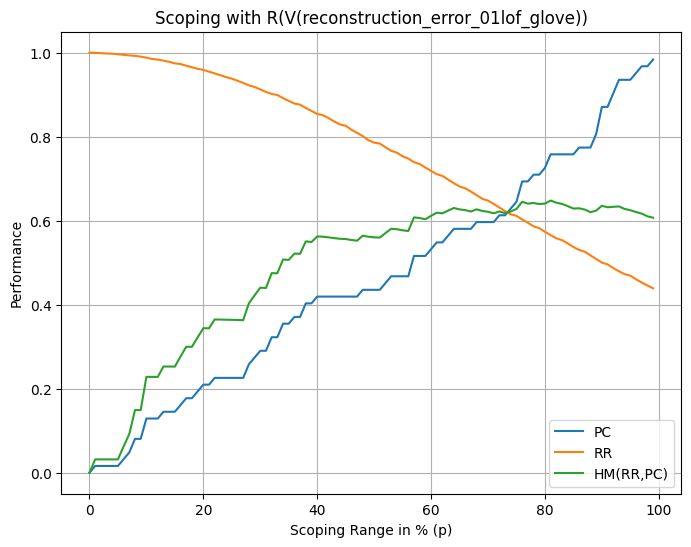

AUC PC (trapezoidal rule):  45.29838709677419
AUC HM (trapezoidal rule):  48.150897422603855


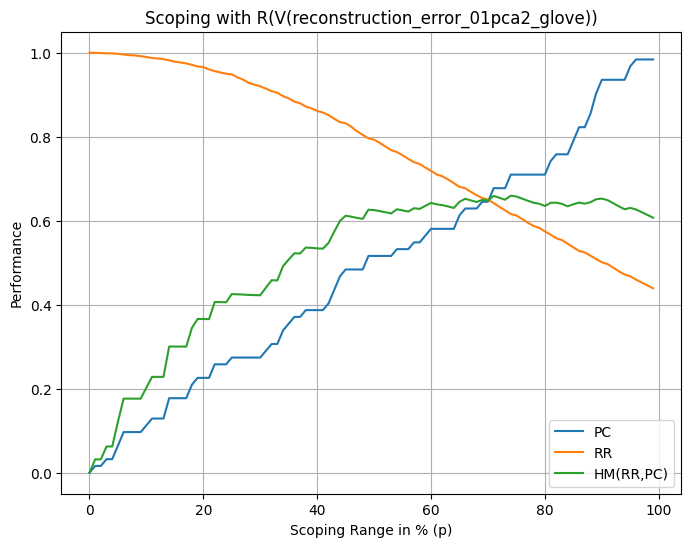

AUC PC (trapezoidal rule):  48.0241935483871
AUC HM (trapezoidal rule):  50.22434268926281


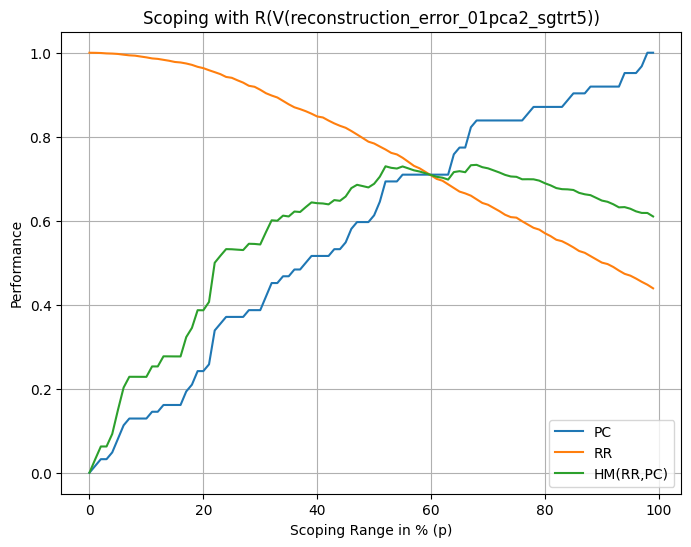

AUC PC (trapezoidal rule):  56.9516129032258
AUC HM (trapezoidal rule):  55.97805508399379


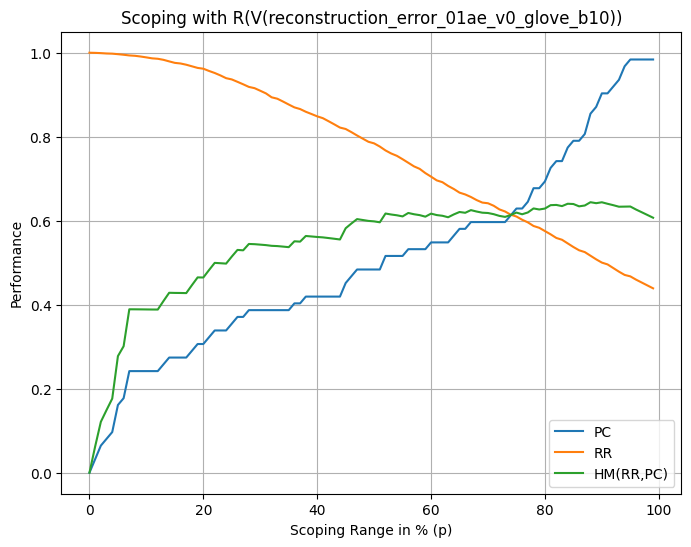

AUC PC (trapezoidal rule):  49.943548387096776
AUC HM (trapezoidal rule):  53.61952929200199


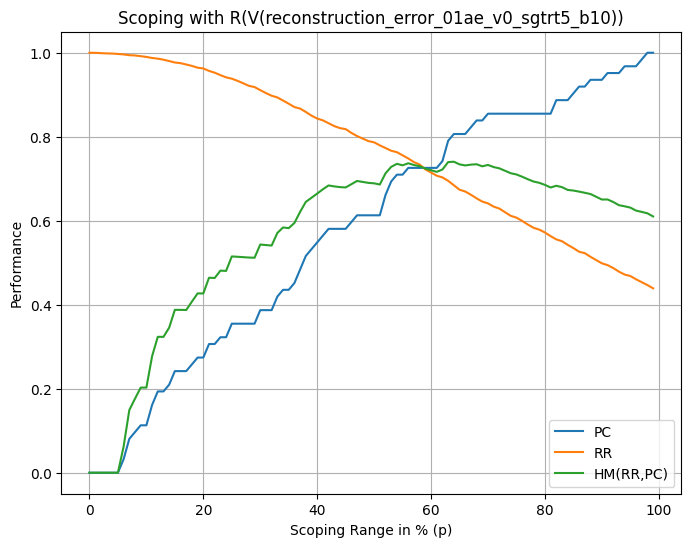

AUC PC (trapezoidal rule):  57.58064516129032
AUC HM (trapezoidal rule):  56.019609816145106


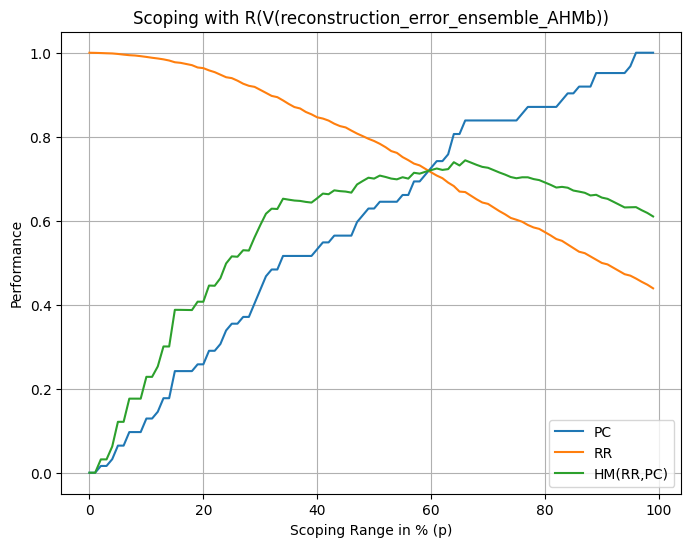

AUC PC (trapezoidal rule):  57.806451612903224
AUC HM (trapezoidal rule):  56.38487190436282


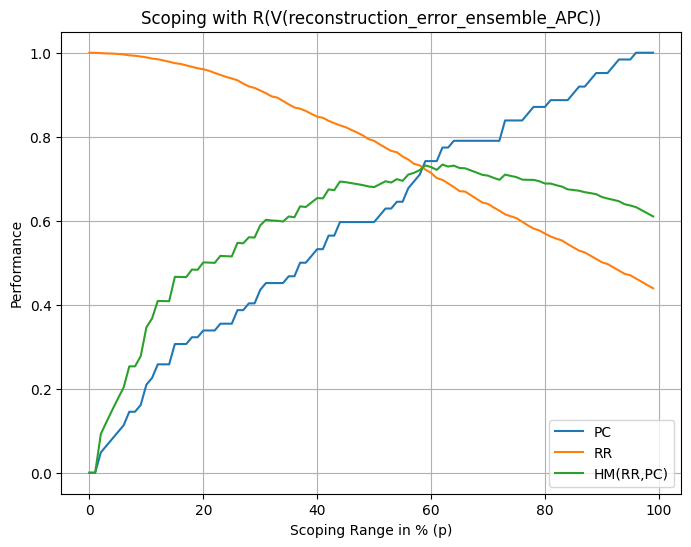

AUC PC (trapezoidal rule):  58.806451612903224
AUC HM (trapezoidal rule):  58.08545133533509


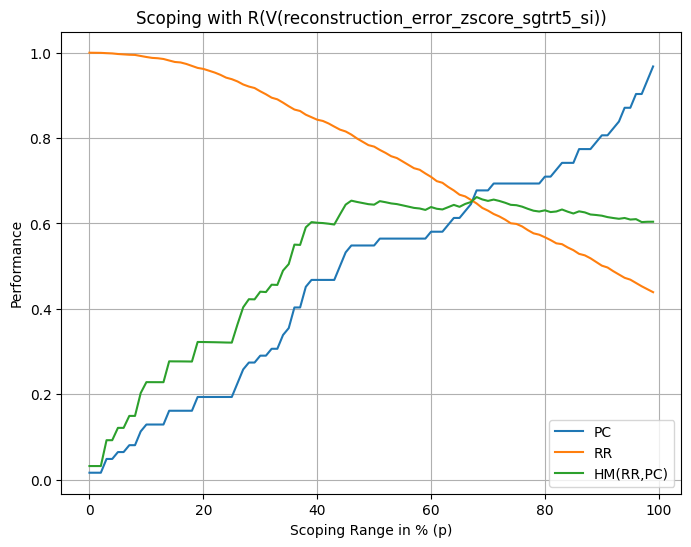

AUC PC (trapezoidal rule):  47.42741935483871
AUC HM (trapezoidal rule):  49.86418515804309


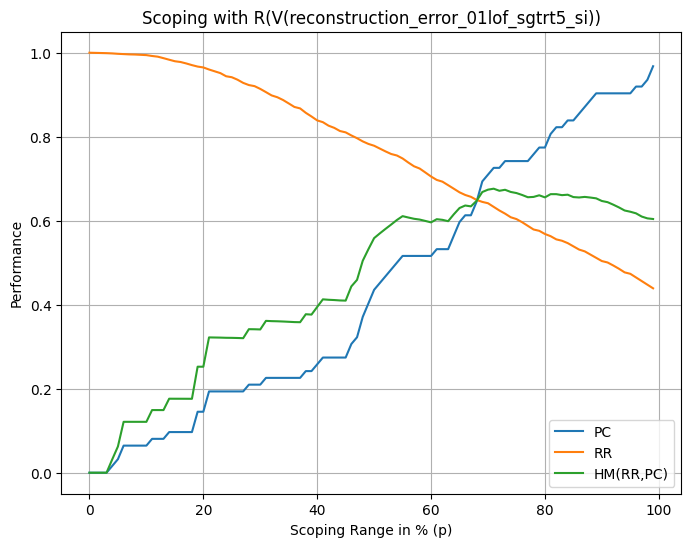

AUC PC (trapezoidal rule):  43.72580645161291
AUC HM (trapezoidal rule):  44.8137296052148


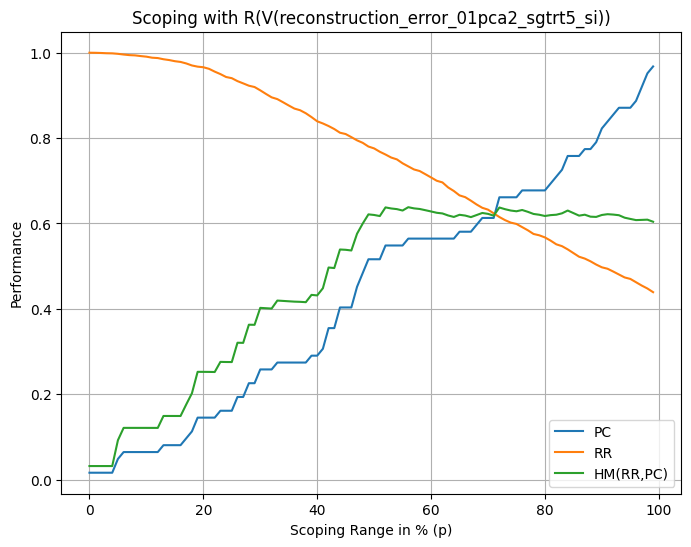

AUC PC (trapezoidal rule):  43.31451612903226
AUC HM (trapezoidal rule):  45.51506344729654


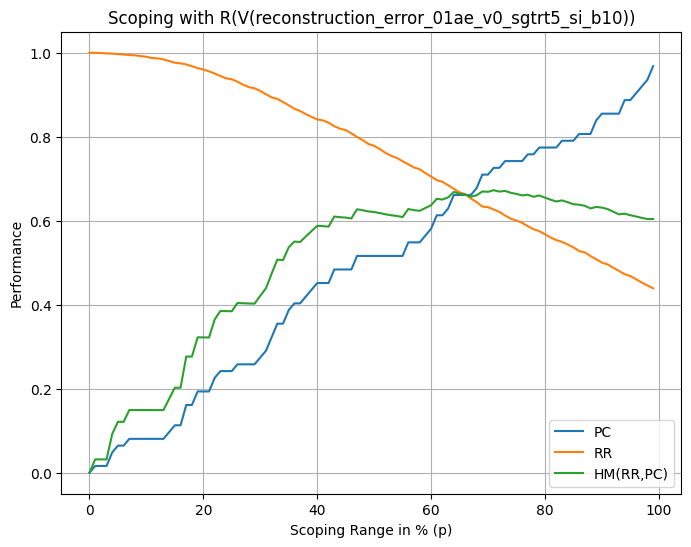

AUC PC (trapezoidal rule):  48.064516129032256
AUC HM (trapezoidal rule):  49.581981299165655


Setting  AUC_PC_trapezoidal  \
0           reconstruction_error_zscore_sgtrt5           54.209677   
1            reconstruction_error_zscore_glove           50.419355   
2            reconstruction_error_01lof_sgtrt5           57.112903   
3             reconstruction_error_01lof_glove           45.298387   
4            reconstruction_error_01pca2_glove           48.024194   
5           reconstruction_error_01pca2_sgtrt5           56.951613   
6       reconstruction_error_01ae_v0_glove_b10           49.943548   
7      reconstruction_error_01ae_v0_sgtrt5_b10           57.580645   
8           reconstruction_error_ensemble_AHMb           57.806452   
9            reconstruction_error_ensemble_APC           58.806452   
10       reconstruction_error_zscore_sgtrt5_si           47.427419   
11        reconstruction_error_01lof_sgtrt5_si           43.725806   
12       reconstruction_error_01pca2_sgtrt5_si           43.314516   
13  reconstruction_error_01ae_v0_sgtrt5_si_b10           48.064516   

    AUC_HM_trapezoidal  
0            53.612856  
1            53.428324  
2            55.413674  
3            48.150897  
4            50.224343  
5            55.978055  
6            53.619529  
7            56.019610  
8            56.384872  
9            58.085451  
10           49.864185  
11           44.813730  
12           45.515063  
13           49.581981

In [324]:
auc = []
for eval_col in df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("reconstruction_error")]:
  #print(get_signature_variant_from_method(eval_col))
  auc.append(performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA,
                                  ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA,
                                  eval_col,
                                  gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, k=50,
                                  signature_variant=get_signature_variant_from_method(eval_col)))
pd.DataFrame(auc, columns=["Setting", "AUC_PC_trapezoidal", "AUC_HM_trapezoidal"])

## Source Participation

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns

Index(['id', 'refined_local_name', 'parent_id', 'refined_local_name_p',
       'schema', 'vec_datatype_numeric', 'vec_datatype_text',
       'vec_datatype_date', 'vec_datatype_miscellaneous', 'vec_constraint_pk',
       'vec_constraint_fk', 'vec_constraint_notnull', 'vec_constraint_default',
       'vec_constraint_unique', 'vec_constaint_check', 'concept_concat_info',
       'concept_concat_sgtrt5', 'concept_concat_sgtrt5_dtype_constraints',
       'reconstruction_error_zscore_sgtrt5',
       'reconstruction_error_zscore_glove',
       'reconstruction_error_01lof_sgtrt5', 'reconstruction_error_01lof_glove',
       'reconstruction_error_01pca2_glove',
       'reconstruction_error_01pca2_sgtrt5',
       'reconstruction_error_01ae_v0_glove_b10',
       'reconstruction_error_01ae_v0_sgtrt5_b10',
       'reconstruction_error_ensemble_AHMb',
       'reconstruction_error_ensemble_APC',
       'concept_concat_schema_instances_sgtrt5',
       'reconstruction_error_zscore_sgtrt5_si',
       'rec

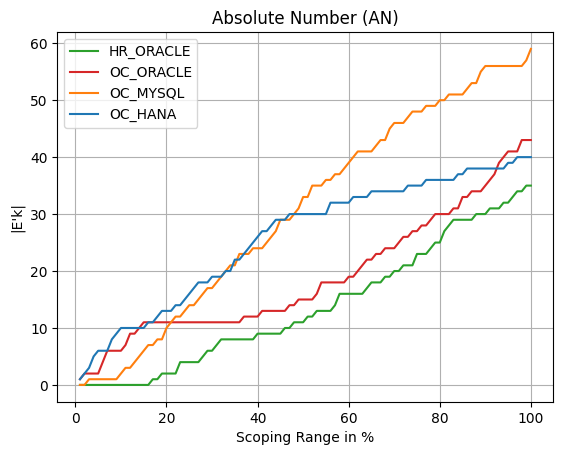

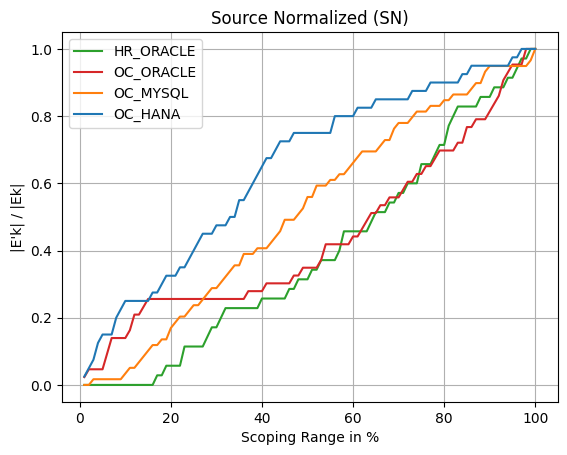

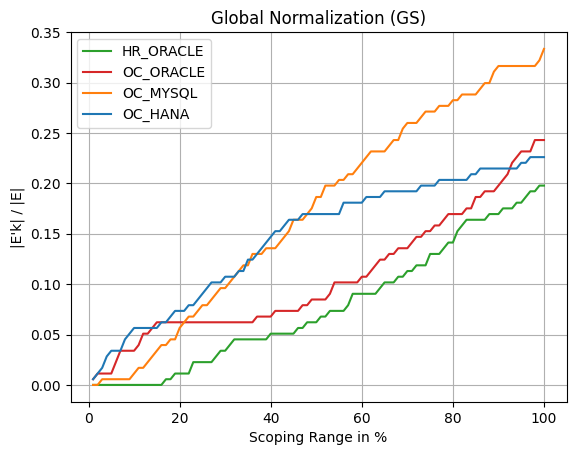

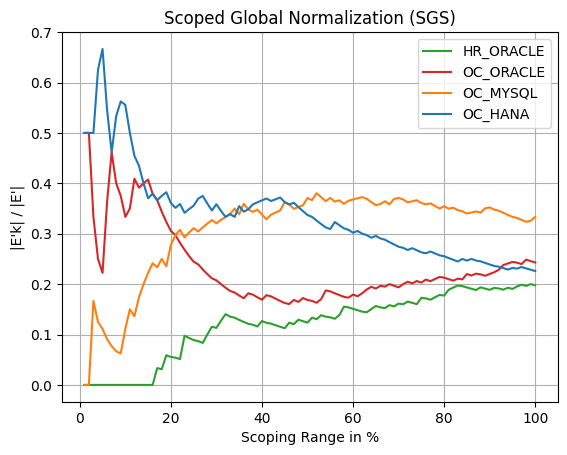

In [ ]:
source_participation_absolute(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01lof_sgtrt5", 1)
source_participation_local_relative(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01lof_sgtrt5", 1)
source_participation_global_relative(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01lof_sgtrt5", 1)
source_participation_scoped_global_relative(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01lof_sgtrt5", 1)

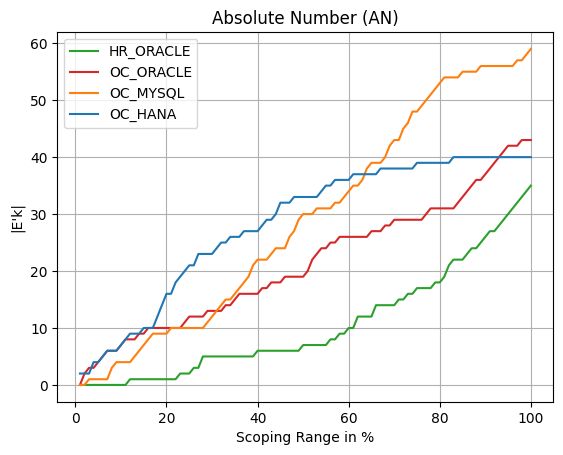

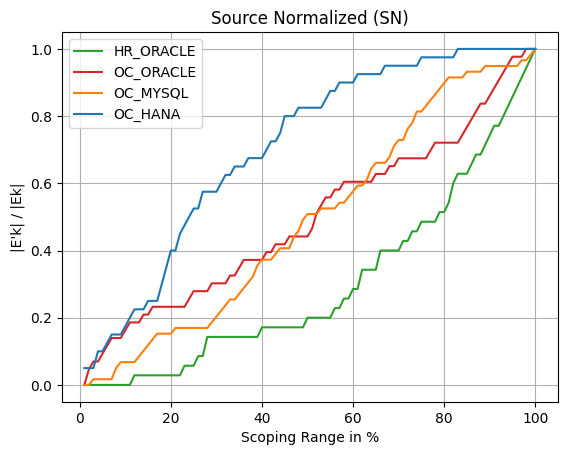

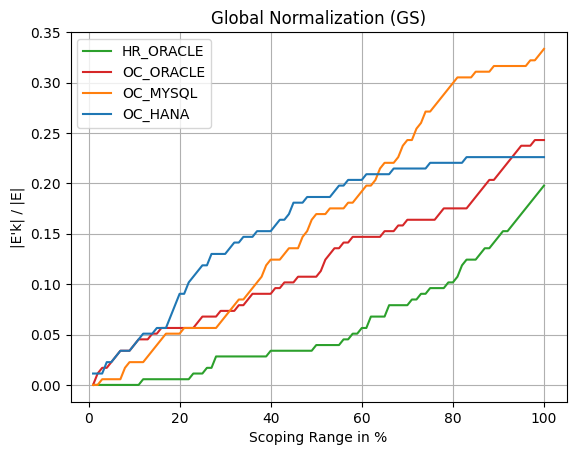

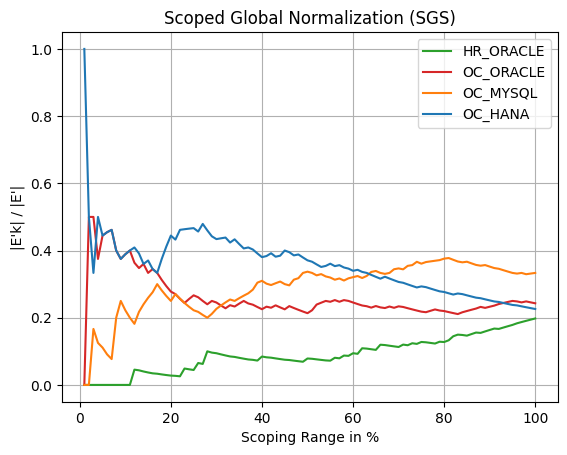

In [ ]:
source_participation_absolute(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", 1)
source_participation_local_relative(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", 1)
source_participation_global_relative(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", 1)
source_participation_scoped_global_relative(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", 1)